# **3 Classification Methods**
**2. Multi-view + CNN from Scratch:**
Train a convolutional neural network from scratch using multi-view data

**But principal:**

L’objectif de cette méthode est d’entraîner un réseau de neurones convolutif (CNN) directement à partir des données multivues des arbres, sans utiliser de modèles pré-entraînés.

**Fonctionnement:**

Chaque arbre est représenté par plusieurs images (vues différentes).

Les images sont traitées par un CNN construit de zéro, avec des couches convolutionnelles, de pooling et fully-connected.

Le réseau apprend à extraire automatiquement des caractéristiques discriminantes à partir des pixels bruts.

L’entraînement se fait en utilisant uniquement les données du dataset fourni (aucun transfert d’apprentissage).

Utilisation
Cette approche permet d’évaluer la capacité d’un CNN simple, entraîné sur mesure, à exploiter la richesse de l’information multivue.
Elle sert aussi de baseline pour comparer les performances avec d’autres méthodes (par ex. transfert learning, MVCNN, ou modèles hybrides).

**1-Patch Express – Montage Drive et Détection du Dataset:**

In [ ]:
# --- PATCH EXPRESS : monter Drive + auto-trouver ROOT ---
from pathlib import Path
import itertools

# Monte Drive si nécessaire (Colab)
try:
    from google.colab import drive  # type: ignore
    drive.mount("/content/drive", force_remount=True)
except Exception:
    pass

MYDRIVE = Path("/content/drive/MyDrive")

# Candidats usuels (ajoute/modifie selon ton arbo)
candidates = [
    MYDRIVE / "trees_dataset" / "data_multiview_V8_384_matplotlib",
    MYDRIVE / "data_multiview_V8_384_matplotlib",
    MYDRIVE / "datasets" / "trees_dataset" / "data_multiview_V8_384_matplotlib",
    MYDRIVE / "trees_dataset",  # racine (au cas où les classes sont directement dedans)
]

# Recherche glob de secours
glob_hits = []
for pat in ["**/data_multiview*384*", "**/multiview*", "**/trees*multiview*"]:
    try:
        for p in MYDRIVE.glob(pat):
            if p.is_dir():
                glob_hits.append(p)
    except Exception:
        pass

# Filtre : dossier qui contient des images (scan rapide)
IMG_EXTS = {".png",".jpg",".jpeg",".bmp",".tif",".tiff"}
def dir_has_images(d: Path, max_probe=400) -> bool:
    seen = 0
    for sub in d.rglob("*"):
        if sub.is_file() and sub.suffix.lower() in IMG_EXTS:
            return True
        seen += 1
        if seen >= max_probe:
            break
    return False

ROOT = None
for p in itertools.chain(candidates, glob_hits):
    if p.exists() and p.is_dir() and dir_has_images(p):
        ROOT = p
        break

if ROOT is None:
    # Aide visuelle : liste quelques dossiers de MyDrive
    print("⚠️  Dataset introuvable automatiquement dans MyDrive.")
    print("→ Vérifie l’upload ou ajuste ‘candidates’ ci-dessus.")
    for d in list(MYDRIVE.iterdir())[:30]:
        print(" -", d)
    raise FileNotFoundError("Aucun dossier contenant des images n’a été trouvé.")
else:
    print("✅ ROOT résolu :", ROOT)


Mounted at /content/drive
✅ ROOT résolu : /content/drive/MyDrive/trees_dataset/data_multiview_V8_384_matplotlib


**2-Normalisation et préparation multi-view (train/val/test):**
Préparer et normaliser les données multivues pour la Méthode 2 (CNN entraîné depuis zéro) : construire un index d’arbres multi-vues, vérifier l’intégrité des vues, estimer les statistiques (mean/std) sur l’ensemble d’entraînement en niveaux de gris, créer des Dataset/DataLoader adaptés (avec normalisation et augmentations) et effectuer des vérifications rapides (sanity checks).


In [ ]:
# -*- coding: utf-8 -*-
"""
M2 — NORMALISATION (sans CSV) avec train/test (val auto)
Étapes :
  1) Scan & index multi-vues par arbre (auto-détection A/B/C)
  2) Vérifs (V vues, unicité, récap)
  3) Estimation mean/std GRAYSCALE sur TRAIN
  4) Datasets/DataLoaders avec Normalize
  5) Sanity checks
"""
from __future__ import annotations
from pathlib import Path
import re, random
from dataclasses import dataclass
from typing import List, Dict, Tuple
from collections import defaultdict, Counter

import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

# -------------------------
# CONFIG
# -------------------------
try:
    from _dataset_root import ROOT as _AUTO_ROOT  # (si tu as lancé la Cellule 0)
except Exception:
    _AUTO_ROOT = None

ROOT        = _AUTO_ROOT or Path("/content/drive/MyDrive/trees_dataset/data_multiview_V8_384_matplotlib")
V_EXPECTED  = 8
IMG_SIZE    = 384
GRAYSCALE   = True
BATCH_TREES = 6
WORKERS     = 2
SEED        = 42

# si pas de dossier val/, on prélève une part de train → val
VAL_RATIO   = 0.20

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(SEED)

IMG_EXTS = {".png",".jpg",".jpeg",".bmp",".tif",".tiff"}

def _nat_key(p: Path):
    s = p.stem
    nums = re.findall(r"\d+", s)
    return (s, tuple(int(x) for x in nums))

@dataclass
class TreeRecord:
    subset: str
    class_name: str
    tree_id: str
    view_paths: List[str]

# -------------------------
# 1) Scan FS (auto)
# -------------------------
def existing_subset_dirs(root: Path) -> List[str]:
    return [d for d in ("train","val","test") if (root/d).exists()]

def scan_subsets(root: Path, subset_names: List[str]) -> List[TreeRecord]:
    recs: List[TreeRecord] = []
    for subset in subset_names:
        subdir = root / subset
        if not subdir.exists(): continue
        for class_dir in sorted([d for d in subdir.iterdir() if d.is_dir()]):
            cname = class_dir.name
            for tree_dir in sorted([d for d in class_dir.iterdir() if d.is_dir()]):
                imgs = sorted([p for p in tree_dir.iterdir() if p.suffix.lower() in IMG_EXTS], key=_nat_key)
                if imgs: recs.append(TreeRecord(subset, cname, tree_dir.name, [str(p) for p in imgs]))
    return recs

def scan_class_layout(root: Path, ratios={"train":0.60,"val":0.15,"test":0.25}, seed=SEED) -> List[TreeRecord]:
    by_class: Dict[str, List[TreeRecord]] = {}
    for class_dir in sorted([d for d in root.iterdir() if d.is_dir()]):
        cname = class_dir.name
        lst: List[TreeRecord] = []
        for tree_dir in sorted([d for d in class_dir.iterdir() if d.is_dir()]):
            imgs = sorted([p for p in tree_dir.iterdir() if p.suffix.lower() in IMG_EXTS], key=_nat_key)
            if imgs: lst.append(TreeRecord("train", cname, tree_dir.name, [str(p) for p in imgs]))
        if lst: by_class[cname] = lst
    recs: List[TreeRecord] = []
    rng = random.Random(seed)
    for cname, trees in by_class.items():
        rng.shuffle(trees)
        n = len(trees)
        n_train = max(1, int(round(ratios["train"] * n))) if n >= 3 else max(1, n-1)
        n_val   = max(1, int(round(ratios["val"]   * n))) if n >= 4 else (1 if n>=3 else 0)
        if n_train + n_val > n-1: n_val = max(0, (n-1)-n_train)
        for i, r in enumerate(trees):
            subset = "train" if i < n_train else ("val" if i < n_train+n_val else "test")
            recs.append(TreeRecord(subset, r.class_name, r.tree_id, r.view_paths))
    return recs

def split_val_from_train(records: List[TreeRecord], val_ratio=VAL_RATIO, seed=SEED) -> int:
    rng = random.Random(seed)
    by_class: Dict[str, Dict[str, List[int]]] = defaultdict(lambda: defaultdict(list))
    for i, r in enumerate(records):
        if r.subset == "train":
            by_class[r.class_name][r.tree_id].append(i)
    moved = 0
    for cname, trees in by_class.items():
        tids = list(trees.keys()); n = len(tids)
        if n <= 1: continue
        k = max(1 if n>=3 else 0, int(round(val_ratio*n))); k = min(k, n-1)
        rng.shuffle(tids)
        for tid in tids[:k]:
            for idx in trees[tid]:
                records[idx].subset = "val"
                moved += 1
    return moved

existing = existing_subset_dirs(ROOT)
if existing:
    print(f"• Subsets présents → {existing}")
    RECS = scan_subsets(ROOT, existing)
    if "val" not in existing and "train" in existing:
        moved = split_val_from_train(RECS, VAL_RATIO, SEED)
        print(f"(info) VAL créé depuis TRAIN : {moved} vues (regroupées par arbre)")
else:
    print("• Pas de train/val/test → split auto (ROOT/<classe>/<tree_id>/*)")
    RECS = scan_class_layout(ROOT)

# -------------------------
# 2) Vérifs / Réduction aux arbres complets
# -------------------------
filtered: List[TreeRecord] = []
skip_counts = defaultdict(int)
for r in RECS:
    if len(r.view_paths) != V_EXPECTED:
        skip_counts[(r.subset,"views!=V")] += 1
        continue
    filtered.append(r)
RECS = filtered

# unicité (subset, tree_id)
seen = set(); dups = []
for r in RECS:
    key = (r.subset, r.tree_id)
    if key in seen: dups.append(key)
    seen.add(key)
assert not dups, f"Doublons (subset,tree_id): {dups[:5]}"

classes = sorted({r.class_name for r in RECS})
by_subset = defaultdict(list)
for r in RECS: by_subset[r.subset].append(r)

n_train, n_val, n_test = map(lambda k: len(by_subset.get(k,[])), ("train","val","test"))
print(f"✓ Index: total={len(RECS)} | train={n_train} val={n_val} test={n_test}")
print(f"✓ Classes: {classes}")
if skip_counts: print("(info) arbres ignorés:", dict(skip_counts))
assert n_train>0, "Aucun arbre en TRAIN → vérifie ROOT / structure."

# -------------------------
# 3) Estimation mean/std (TRAIN)
# -------------------------
def estimate_gray_mean_std(records: List[TreeRecord], img_size=IMG_SIZE, max_images=None) -> Tuple[float,float]:
    paths = []
    for r in records: paths.extend(r.view_paths)
    if not paths: raise RuntimeError("TRAIN vide pour estimer mean/std. Ajuste VAL_RATIO ou ROOT.")
    if max_images is not None: paths = paths[:max_images]
    s=0.0; ss=0.0; n_pix=0
    for p in paths:
        im = Image.open(p).convert("L").resize((img_size,img_size), Image.BILINEAR)
        arr = np.asarray(im, np.float32)/255.0
        s += float(arr.sum()); ss += float((arr*arr).sum()); n_pix += arr.size
    mean = s/n_pix; var = ss/n_pix - mean*mean; std = float(np.sqrt(max(var,1e-12)))
    return float(mean), std

TRAIN_RECS = [r for r in RECS if r.subset=="train"]
MEAN, STD = estimate_gray_mean_std(TRAIN_RECS, IMG_SIZE)
print(f"✓ Stats TRAIN (gray): mean={MEAN:.6f}  std={STD:.6f}")

# -------------------------
# 4) Datasets / Loaders (+ Normalize)
# -------------------------
class MultiViewFSDataset(Dataset):
    def __init__(self, records: List[TreeRecord], classes: List[str], augment: bool):
        self.records = records
        self.classes = classes
        self.class_to_idx = {c:i for i,c in enumerate(classes)}
        base = [T.Grayscale(1)] if GRAYSCALE else []
        base += [T.Resize((IMG_SIZE,IMG_SIZE), antialias=True)]
        aug  = [T.RandomHorizontalFlip(0.5),
                T.RandomRotation(15),
                T.RandomAffine(degrees=0, translate=(0.05,0.05), scale=(0.95,1.05), shear=3, fill=255)] if augment else []
        norm = [T.ToTensor(),
                T.Normalize(mean=[MEAN] if GRAYSCALE else [0.485,0.456,0.406],
                            std=[STD]  if GRAYSCALE else [0.229,0.224,0.225])]
        erase= [T.RandomErasing(p=0.25, value=0.0)] if augment else []
        self.tf = T.Compose(base + aug + norm + erase)
    def __len__(self): return len(self.records)
    def __getitem__(self, idx):
        r = self.records[idx]
        imgs=[]
        for p in r.view_paths:
            try: img = Image.open(p).convert("RGB")
            except Exception: img = Image.fromarray(np.full((IMG_SIZE,IMG_SIZE,3),255,np.uint8))
            imgs.append(self.tf(img))
        X = torch.stack(imgs, 0)               # (V,1,H,W)
        y = torch.tensor(self.class_to_idx[r.class_name], dtype=torch.long)
        return X, y, (r.subset, r.class_name, r.tree_id)

classes_sorted = classes
train_ds = MultiViewFSDataset([r for r in RECS if r.subset=="train"], classes_sorted, augment=True)
val_ds   = MultiViewFSDataset([r for r in RECS if r.subset=="val"],   classes_sorted, augment=False)
test_ds  = MultiViewFSDataset([r for r in RECS if r.subset=="test"],  classes_sorted, augment=False)

pin = torch.cuda.is_available()
train_ld = DataLoader(train_ds, batch_size=BATCH_TREES, shuffle=True,  num_workers=WORKERS, pin_memory=pin)
val_ld   = DataLoader(val_ds,   batch_size=BATCH_TREES, shuffle=False, num_workers=WORKERS, pin_memory=pin)

def describe_split(name: str, ds: MultiViewFSDataset):
    c = Counter([r.class_name for r in RECS if r.subset==name])
    print(f"{name}: {len(ds)} arbres | classes→", dict(sorted(c.items())))
describe_split("train", train_ds)
describe_split("val",   val_ds)
describe_split("test",  test_ds)

# -------------------------
# 5) Sanity checks
# -------------------------
if len(train_ds)==0: raise RuntimeError("TRAIN vide après split/filtrage.")
X, y, meta = next(iter(train_ld))
print("post-norm mean/std ≈ (0,1):", float(X.mean()), float(X.std()))
print("X shape:", tuple(X.shape), "; y shape:", tuple(y.shape))
print("meta[0..2]:", meta[:2])

# Option : sauvegarder les stats
import json
with open("./gray_stats_train.json","w") as f:
    json.dump({"mean":MEAN, "std":STD, "img_size":IMG_SIZE, "grayscale":GRAYSCALE, "V":V_EXPECTED}, f, indent=2)
print("✓ Stats sauvegardées → ./gray_stats_train.json")


• Subsets présents → ['train', 'test']
(info) VAL créé depuis TRAIN : 52 vues (regroupées par arbre)
✓ Index: total=339 | train=206 val=52 test=81
✓ Classes: ['Ash', 'Oak', 'Red_Oak', 'beech', 'douglas_fir', 'pine', 'spruce']
✓ Stats TRAIN (gray): mean=0.978607  std=0.108668
train: 206 arbres | classes→ {'Ash': 26, 'Oak': 14, 'Red_Oak': 64, 'beech': 5, 'douglas_fir': 74, 'pine': 16, 'spruce': 7}
val: 52 arbres | classes→ {'Ash': 6, 'Oak': 4, 'Red_Oak': 16, 'beech': 1, 'douglas_fir': 19, 'pine': 4, 'spruce': 2}
test: 81 arbres | classes→ {'Ash': 7, 'Oak': 4, 'Red_Oak': 20, 'beech': 7, 'douglas_fir': 31, 'pine': 5, 'spruce': 7}
post-norm mean/std ≈ (0,1): -0.3178618848323822 1.9227182865142822
X shape: (6, 8, 1, 384, 384) ; y shape: (6,)
meta[0..2]: [['train', 'train', 'train', 'train', 'train', 'train'], ['Red_Oak', 'douglas_fir', 'douglas_fir', 'pine', 'pine', 'douglas_fir']]
✓ Stats sauvegardées → ./gray_stats_train.json


In [ ]:
# --- utilitaires / constantes ---
import re, random

# extensions d’images (utilisées par scan_subsets / scan_class_layout)
try:
    _IMG_EXTS
except NameError:
    _IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

def _norm_cls(name: str) -> str:
    # normalise les noms de classes -> snake_case minuscule
    return re.sub(r'[^a-z0-9]+', '_', name.strip().lower()).strip('_')


**3-Gestion des sous-ensembles (train / val / test)**

In [ ]:
existing = existing_subset_dirs(ROOT)
if existing:
    RECS = scan_subsets(ROOT, existing)
    if 'val' not in existing and 'train' in existing:
        moved = split_val_from_train(RECS, val_ratio=0.20, seed=SEED)  # ou ta version min_per_class
        print(f"(info) VAL depuis TRAIN: {moved} vues")
else:
    RECS = scan_class_layout(ROOT)

classes = sorted({r.class_name for r in RECS})
print("Classes normalisées:", classes)


(info) VAL depuis TRAIN: 52 vues
Classes normalisées: ['Ash', 'Oak', 'Red_Oak', 'beech', 'douglas_fir', 'pine', 'spruce']


**4-Re-scan du dataset + création éventuelle de val + estimation des stats**

*But principal:*

Ce bloc permet de :

Re-scanner la structure du dataset à partir de ROOT.

Créer un sous-ensemble val à partir de train si celui-ci est manquant.

Extraire la liste des classes et les afficher.

Calculer les statistiques d’intensité (mean, std) sur l’ensemble train, en vue de normaliser les images.

In [ ]:
# re-scan + (re)création éventuelle de val
existing = existing_subset_dirs(ROOT)
if existing:
    RECS = scan_subsets(ROOT, existing)
    if 'val' not in existing and 'train' in existing:
        _ = split_val_from_train(RECS, val_ratio=0.20, seed=SEED)  # garde ta version min_per_class si tu l'as
else:
    RECS = scan_class_layout(ROOT)

classes = sorted({r.class_name for r in RECS})
print("Classes normalisées:", classes)

# stats TRAIN
TRAIN_RECS = [r for r in RECS if r.subset=='train']
MEAN, STD = estimate_gray_mean_std(TRAIN_RECS, IMG_SIZE)
print(f"MEAN={MEAN:.6f}  STD={STD:.6f}")


NameError: name 'existing_subset_dirs' is not defined

**5-Datasets / DataLoaders + Modèle CNN (ResNetMini) + Classifier multi-view**


Préparer les Dataset/DataLoader pour les arbres multi-vues (batch par arbre, toutes les vues empilées) et définir un petit réseau convolutionnel (ResNetMini) + wrapper MultiViewClassifier qui agrége les prédictions/des logits sur les V vues (moyenne des logits).

In [ ]:
classes_sorted = classes
train_ds = MultiViewFSDataset([r for r in RECS if r.subset=='train'], classes_sorted, augment=True)
val_ds   = MultiViewFSDataset([r for r in RECS if r.subset=='val'],   classes_sorted, augment=False)
test_ds  = MultiViewFSDataset([r for r in RECS if r.subset=='test'],  classes_sorted, augment=False)

pin = torch.cuda.is_available()
train_ld = DataLoader(train_ds, batch_size=6, shuffle=True,  num_workers=2, pin_memory=pin)
val_ld   = DataLoader(val_ds,   batch_size=6, shuffle=False, num_workers=2, pin_memory=pin)

# sanity check sans augments (normalisation pure)
val_clean = MultiViewFSDataset([r for r in RECS if r.subset=='val'], classes_sorted, augment=False)
X0,_,_ = next(iter(DataLoader(val_clean, batch_size=6, shuffle=False)))
print("post-norm (no aug):", float(X0.mean()), float(X0.std()))


post-norm (no aug): 0.02214576117694378 0.9535950422286987


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, 3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, 3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)
        self.down  = None
        if stride != 1 or in_planes != planes:
            self.down = nn.Sequential(
                nn.Conv2d(in_planes, planes, 1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        skip = x if self.down is None else self.down(x)
        return F.relu(out + skip)

class ResNetMini(nn.Module):
    def __init__(self, num_classes: int, widths=(32,64,128,256), in_ch=1, drop=0.2):
        super().__init__()
        c1,c2,c3,c4 = widths
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, c1, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(c1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1),
        )
        self.layer1 = nn.Sequential(BasicBlock(c1,c1,1), BasicBlock(c1,c1,1))
        self.layer2 = nn.Sequential(BasicBlock(c1,c2,2), BasicBlock(c2,c2,1))
        self.layer3 = nn.Sequential(BasicBlock(c2,c3,2), BasicBlock(c3,c3,1))
        self.layer4 = nn.Sequential(BasicBlock(c3,c4,2), BasicBlock(c4,c4,1))
        self.pool   = nn.AdaptiveAvgPool2d(1)
        self.head   = nn.Sequential(nn.Dropout(drop), nn.Linear(c4, num_classes))
        # init Kaiming
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0); nn.init.constant_(m.bias, 0.0)

    def forward(self, x):           # x: (B*V, C, H, W)
        x = self.stem(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        x = self.pool(x).flatten(1)
        return self.head(x)

class MultiViewClassifier(nn.Module):
    def __init__(self, base: nn.Module, num_classes: int):
        super().__init__()
        self.base = base
        self.num_classes = num_classes

    def forward(self, X):           # X: (B, V, C, H, W)
        B,V,C,H,W = X.shape
        logits = self.base(X.view(B*V, C, H, W)).view(B, V, self.num_classes)
        return logits.mean(1)       # moyenne des logits sur les V vues


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base   = ResNetMini(num_classes=len(classes_sorted), widths=(32,64,128,256), in_ch=1)
model  = MultiViewClassifier(base, len(classes_sorted)).to(device)


**6-Gestion du déséquilibre des classes et loss pondérée:**

Assurer un entraînement équilibré du CNN multi-vues lorsque certaines classes sont sous-représentées dans l’ensemble train.


Création d’un WeightedRandomSampler pour équilibrer le tirage des arbres.


Calcul des class weights pour CrossEntropyLoss avec label smoothing.


`*Fonctionnement (points clés)*`

WeightedRandomSampler par arbre

make_tree_sampler(dataset) :

Récupère les labels de chaque arbre (dataset.records).

Compte le nombre d’exemples par classe et calcule l’inverse (1/count) pour pondérer les classes minoritaires.

Normalise les poids pour que la somme soit égale à la taille du dataset.

Résultat : sampler que l’on passe au DataLoader pour l’entraînement (train_ld) afin que chaque batch soit équilibré.

Class-balanced weights pour la loss

class_balanced_weights(counts, beta=0.999) :

counts = dict {classe: nombre d’arbres dans train}.

Formule basée sur Effective Number of Samples (eff_num = 1 - beta^n) pour calculer un poids plus réaliste pour les classes minoritaires.

Normalisation pour que la somme des poids soit égale au nombre de classes.

Utilisé comme weight dans torch.nn.CrossEntropyLoss.

Loss

CrossEntropyLoss(weight=class_weights, label_smoothing=0.02) :

weight : corrige le déséquilibre des classes.

label_smoothing=0.02 : atténue légèrement la confiance des labels pour régulariser le modèle.

In [ ]:
import numpy as np, torch
from collections import Counter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ⚠️ in_ch=1 car on est en GRAYSCALE
base  = ResNetMini(num_classes=len(classes_sorted), widths=(32,64,128,256), in_ch=1)
model = MultiViewClassifier(base, len(classes_sorted)).to(device)

# Poids de classes par ARBRE (TRAIN)
cnt = Counter([r.class_name for r in TRAIN_RECS])
w = np.array([1.0/max(cnt[c],1) for c in classes_sorted], dtype=np.float32)
w = w * (len(w)/w.sum())
class_weights = torch.tensor(w, device=device)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)


In [ ]:
# dans MultiViewFSDataset (augment=True)
aug  = [
    T.RandomHorizontalFlip(0.5),
    T.RandomRotation(20, fill=255),
    T.RandomAffine(degrees=0, translate=(0.08,0.08), scale=(0.90,1.10), shear=6, fill=255),
    T.RandomPerspective(distortion_scale=0.3, p=0.25),   # + de diversité
]
# retire RandomErasing au début, tu le remettras plus tard si besoin


In [ ]:
@torch.no_grad()
def predict_tta(model, X, n_tta=2):
    # X: (B,V,C,H,W)
    B,V,C,H,W = X.shape
    outs = []
    for t in range(n_tta):
        if t == 0:
            Xt = X
        else:
            Xt = X.flip(-1)  # flip horizontal simple
        outs.append(model(Xt).softmax(1))
    return torch.stack(outs, 0).mean(0)  # (B,num_classes)

# usage (VAL/TEST) :
probs = predict_tta(model, X)
preds = probs.argmax(1)


In [ ]:
class MultiViewClassifier(nn.Module):
    def __init__(self, base, num_classes, mode="mean"):  # "mean" | "max"
        super().__init__()
        self.base, self.num_classes, self.mode = base, num_classes, mode
    def forward(self, X):
        B,V,C,H,W = X.shape
        logits = self.base(X.view(B*V,C,H,W)).view(B,V,self.num_classes)
        return logits.amax(dim=1) if self.mode=="max" else logits.mean(dim=1)

# essayer:
model = MultiViewClassifier(base, len(classes_sorted), mode="max")


In [ ]:
from _dataset_root import ROOT
print("Using ROOT =", ROOT)

# re-scan (tes fonctions de scan normalisées)
existing = existing_subset_dirs(ROOT)
if existing:
    RECS = scan_subsets(ROOT, existing)
    if 'val' not in existing and 'train' in existing:
        _ = split_val_from_train(RECS, val_ratio=0.20, seed=SEED)  # garde ta variante min_per_class si tu l’as
else:
    RECS = scan_class_layout(ROOT)

# classes normalisées
classes_sorted = sorted({r.class_name for r in RECS})
print("Classes:", classes_sorted)

# stats TRAIN (grayscale)
TRAIN_RECS = [r for r in RECS if r.subset=='train']
MEAN, STD = estimate_gray_mean_std(TRAIN_RECS, IMG_SIZE)
print(f"MEAN={MEAN:.6f}  STD={STD:.6f}")


Using ROOT = /content/drive/MyDrive/trees_dataset/data_multiview_V8_384_matplotlib
Classes: ['Ash', 'Oak', 'Red_Oak', 'beech', 'douglas_fir', 'pine', 'spruce']
MEAN=0.978607  STD=0.108668


In [ ]:
from pathlib import Path
ROOT = Path("/content/drive/MyDrive/trees_dataset/data_multiview_V8_384_matplotlib")
assert ROOT.exists(), f"Chemin introuvable: {ROOT}"  # ajuste si besoin

# (optionnel) écrire le module pour la prochaine fois
Path("_dataset_root.py").write_text(f"from pathlib import Path\nROOT = Path(r'{str(ROOT)}')\n")
print("Using ROOT =", ROOT)


Using ROOT = /content/drive/MyDrive/trees_dataset/data_multiview_V8_384_matplotlib


In [ ]:
# rebuild datasets/loaders
train_ds = MultiViewFSDataset([r for r in RECS if r.subset=='train'], classes_sorted, augment=True)
val_ds   = MultiViewFSDataset([r for r in RECS if r.subset=='val'],   classes_sorted, augment=False)
test_ds  = MultiViewFSDataset([r for r in RECS if r.subset=='test'],  classes_sorted, augment=False)

from torch.utils.data import DataLoader
pin = torch.cuda.is_available()
train_ld = DataLoader(train_ds, batch_size=6, shuffle=True,  num_workers=2, pin_memory=pin)
val_ld   = DataLoader(val_ds,   batch_size=6, shuffle=False, num_workers=2, pin_memory=pin)

# >>> Patch d’augmentations pour plus de diversité (et retirer RandomErasing au début)
import torchvision.transforms as T
aug_strong = T.Compose([
    T.Grayscale(1),
    T.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    T.RandomHorizontalFlip(0.5),
    T.RandomRotation(20, fill=255),
    T.RandomAffine(degrees=0, translate=(0.08,0.08), scale=(0.90,1.10), shear=6, fill=255),
    T.RandomPerspective(distortion_scale=0.3, p=0.25),
    T.ToTensor(),
    T.Normalize(mean=[MEAN], std=[STD]),
    # pas de RandomErasing pour l’instant
])
base_eval = T.Compose([
    T.Grayscale(1),
    T.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    T.ToTensor(),
    T.Normalize(mean=[MEAN], std=[STD]),
])

# on remplace simplement les transforms
train_ds.tf = aug_strong
val_ds.tf   = base_eval
test_ds.tf  = base_eval


In [ ]:
from torch.utils.data import WeightedRandomSampler
import numpy as np, torch

def make_tree_sampler(dataset):
    labels = [dataset.class_to_idx[r.class_name] for r in dataset.records]
    counts = np.bincount(labels, minlength=len(dataset.classes)).astype(float)
    cls_w  = 1.0 / np.maximum(counts, 1.0)
    sample_w = np.array([cls_w[y] for y in labels], dtype=np.float64)
    sample_w = sample_w * (len(sample_w)/sample_w.sum())
    return WeightedRandomSampler(weights=torch.tensor(sample_w), num_samples=len(sample_w), replacement=True)

train_sampler = make_tree_sampler(train_ds)
train_ld = DataLoader(train_ds, batch_size=6, sampler=train_sampler, num_workers=2, pin_memory=pin)


1️⃣ index_multiview_READY.csv

construire un CSV avec toutes les vues par arbre, leur split (train/val/test), la classe et tree_id

In [ ]:
import pandas as pd
from pathlib import Path

ROOT = Path("/content/drive/MyDrive/trees_dataset/data_multiview_V8_384_matplotlib")
V_EXPECTED = 8
VAL_RATIO = 0.20
SEED = 42

# TreeRecord et fonctions scan_subsets / scan_class_layout / split_val_from_train
# sont déjà dans ton script MultiViewFSDataset

# 1) Scan + split
existing = existing_subset_dirs(ROOT)
if existing:
    RECS = scan_subsets(ROOT, existing)
    if 'val' not in existing and 'train' in existing:
        _ = split_val_from_train(RECS, val_ratio=VAL_RATIO, seed=SEED)
else:
    RECS = scan_class_layout(ROOT)

# 2) Filtrer arbres incomplets
RECS = [r for r in RECS if len(r.view_paths)==V_EXPECTED]

# 3) Créer DataFrame
rows = []
for r in RECS:
    for p in r.view_paths:
        rows.append({"path": p, "class": r.class_name, "tree_id": r.tree_id, "split": r.subset})
df = pd.DataFrame(rows)

# 4) Sauvegarde CSV
CSV_READY = ROOT/"index_multiview_READY.csv"
df.to_csv(CSV_READY, index=False)
print("✅ CSV généré:", CSV_READY)


2️⃣ normalization_train_only.json.

calculer mean et std des images sur le split train uniquement (en grayscale ou RGB).

In [ ]:
import json
from PIL import Image
import numpy as np

TRAIN_RECS = [r for r in RECS if r.subset=='train']
IMG_SIZE = 384
GRAYSCALE = True  # ou False si RGB

def estimate_gray_mean_std(records, img_size=IMG_SIZE):
    paths = [p for r in records for p in r.view_paths]
    s, ss, n_pix = 0.0, 0.0, 0
    for p in paths:
        im = Image.open(p).convert("L" if GRAYSCALE else "RGB").resize((img_size,img_size))
        arr = np.asarray(im, np.float32)/255.0
        s += arr.sum()
        ss += (arr**2).sum()
        n_pix += arr.size
    mean = s/n_pix
    std  = np.sqrt(max(ss/n_pix - mean**2, 1e-12))
    return float(mean), float(std)

MEAN, STD = estimate_gray_mean_std(TRAIN_RECS)
norm_dict = {"mean": MEAN, "std": STD, "img_size": IMG_SIZE, "grayscale": GRAYSCALE}

NORM_JSON = ROOT/"normalization_train_only.json"
with open(NORM_JSON, "w") as f:
    json.dump(norm_dict, f, indent=2)
print("✅ Normalisation sauvegardée:", NORM_JSON)


3️⃣ class_weights_train.json

calculer poids inverse de fréquence pour chaque classe (optionnel : normaliser et clip).

In [ ]:
from collections import Counter
import json

cnt_train = Counter([r.class_name for r in TRAIN_RECS])
classes_sorted = sorted(cnt_train.keys())
weights_inv = {c: 1.0/max(cnt_train[c],1) for c in classes_sorted}

# Normalisation + clip
w_raw = np.array([weights_inv[c] for c in classes_sorted], dtype=np.float32)
w_norm = w_raw / w_raw.mean()
w_norm = np.clip(w_norm, 0.5, 3.0)
weights_norm_dict = {c: float(w) for c,w in zip(classes_sorted, w_norm)}

WEIGHTS_JSON = ROOT/"class_weights_train.json"
with open(WEIGHTS_JSON, "w") as f:
    json.dump({"weights_inverse_freq": weights_norm_dict}, f, indent=2)
print("✅ Class weights sauvegardés:", WEIGHTS_JSON)


**methode 2-version complet:**

1️⃣ Artefacts & configs

index_multiview_READY.csv → dataset multi-vues.

normalization_train_only.json → mean/std pour normalisation.

class_weights_train.json → poids inverse de fréquence par classe.

Checkpoints sauvegardés dans runs/best_scratch.pt.

Paramètres principaux : IMAGE_SIZE=256, BATCH_SIZE=64, EPOCHS=80, POOL_MODE_TRAIN_EVAL="topk3", LABEL_SMOOTH=0.05.

2️⃣ Dataset & Transforms

CsvImageDataset pour charger les images par vue, avec tree_id pour regroupement par arbre.

Augmentations pour train :

RandomResizedCrop, HorizontalFlip, Rotation, ColorJitter

Normalisation MEAN/STD calculée sur train seulement.

Eval : Resize + ToTensor + Normalisation.

3️⃣ Weighted Random Sampler

Basé sur les poids normalisés et clipés pour éviter les extrêmes.

Permet de rééquilibrer les classes rares lors de l’entraînement.

DataLoaders Colab-safe (NUM_WORKERS=0, PIN_MEMORY=False) pour éviter les problèmes de multiprocessing.

4️⃣ Modèle ResNet from scratch

ResidBlock : bloc résiduel simple.

ResNetScratch :

Stem + 4 couches résiduelles

GAP + Dropout + Fully-connected pour num_classes.

Paramètres drop=0.30 et canaux [64, 128, 256, 256].

5️⃣ Loss, Optimizer, Scheduler

CrossEntropyLoss avec class_weights_tensor et label_smoothing=0.05.

Optimizer : AdamW avec weight_decay=2e-4.

Scheduler : CosineAnnealingLR sur EPOCHS.

6️⃣ TTA & Pooling multi-vues

tta_logits(model, x) : flip horizontal → moyenne des logits.

pool_logits_stack(S, mode) : max / mean / topk3 pour combiner vues par arbre.

eval_by_tree(loader, model, use_tta=True, pool_mode) :

Regroupe les vues par tree_id.

Retourne métriques par arbre : macro_f1, balanced_acc, acc, cm, y_true, y_pred.

7️⃣ Entraînement + Early Stopping

Early stopping basé sur macro-F1 sur la validation.

Checkpoint du meilleur modèle enregistré.

Cosine LR step à chaque fin d’epoch.

8️⃣ Évaluation finale

Test des 3 poolings : max, mean, topk3.

Rapport final avec POOL_MODE_TRAIN_EVAL pour VAL et TEST :

f1_macro, balanced_acc, acc, confusion matrix.

In [ ]:
# =========================
# MÉTHODE 2 — MULTI-VIEW + CNN FROM SCRATCH (complet)
# =========================
# - Dataset via index_multiview_READY.csv
# - Normalisation train-only (json)
# - Class weights (json) -> normalisés & clip
# - DataLoader Colab-safe + WeightedRandomSampler
# - ResNet maison (from scratch)
# - Cosine LR + EarlyStopping sur macro-F1 (val, par arbre)
# - Eval par arbre avec TTA et poolings max/mean/topk3
# =========================

# ------- CONFIG -------
from pathlib import Path
ROOT = Path("/content/drive/MyDrive/trees_dataset")

CSV_READY  = ROOT/"index_multiview_READY.csv"
NORM_JSON  = ROOT/"normalization_train_only.json"
WEIGHTS_JSON = ROOT/"class_weights_train.json"
CKPT_PATH  = ROOT/"runs/best_scratch.pt"

IMAGE_SIZE   = 256           # 224 ou 256 (256 recommandé pour conifères)
BATCH_SIZE   = 64
EPOCHS       = 80
SEED         = 42
LR           = 3e-4
WEIGHT_DECAY = 2e-4
DROPOUT      = 0.30
LABEL_SMOOTH = 0.05
POOL_MODE_TRAIN_EVAL = "topk3"  # "max", "mean", "topk3" -> utilisé pour l'early-stopping & l'éval
PATIENCE     = 12             # early stopping patience (en epochs)

# ------- Imports -------
import multiprocessing as mp
try:
    mp.set_start_method("spawn", force=True)
except RuntimeError:
    pass

import json, random, numpy as np, pandas as pd, torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import f1_score, balanced_accuracy_score, accuracy_score, confusion_matrix, classification_report
from tqdm.auto import tqdm

# ------- Seed & device -------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True
set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------- Vérifs d'artefacts -------
assert CSV_READY.exists(), "index_multiview_READY.csv manquant"
assert NORM_JSON.exists(), "normalization_train_only.json manquant"
assert WEIGHTS_JSON.exists(), "class_weights_train.json manquant"
print("✅ Artefacts OK")

# ------- Chargement data & artefacts -------
df = pd.read_csv(CSV_READY)
norm = json.load(open(NORM_JSON, "r"))
MEAN, STD = norm["mean"], norm["std"]

cw_dict = json.load(open(WEIGHTS_JSON, "r"))["weights_inverse_freq"]

# mapping classes (ordre fixe et stable)
classes = sorted(df["class"].unique())
cls2idx = {c:i for i,c in enumerate(classes)}
idx2cls = {i:c for c,i in cls2idx.items()}
print("Classes:", classes)

# ------- Transforms -------
tf_train = T.Compose([
    T.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),
    T.ColorJitter(0.1, 0.1),
    T.ToTensor(),
    T.Normalize(mean=MEAN, std=STD),
])
tf_eval = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=MEAN, std=STD),
])

# ------- Dataset -------
class CsvImageDataset(Dataset):
    def __init__(self, df_split, transform):
        self.df = df_split.reset_index(drop=True)
        self.t  = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r  = self.df.iloc[i]
        x  = Image.open(r["path"]).convert("RGB")
        x  = self.t(x)
        y  = cls2idx[r["class"]]
        tid= str(r["tree_id"])
        return x, y, tid, r["class"]

# splits
df_train = df[df["split"]=="train"].copy()
df_val   = df[df["split"]=="val"].copy()
df_test  = df[df["split"]=="test"].copy()

dset_train = CsvImageDataset(df_train, tf_train)
dset_val   = CsvImageDataset(df_val,   tf_eval)
dset_test  = CsvImageDataset(df_test,  tf_eval)

# Weighted sampler (par vue) selon poids de classe normalisés & clip
w_raw = np.array([cw_dict[c] for c in classes], dtype=np.float32)
w_norm = w_raw / w_raw.mean()
w_norm = np.clip(w_norm, 0.5, 3.0)  # évite extrêmes (aide douglas_fir à compter plus)
class_weights_tensor = torch.tensor(w_norm, dtype=torch.float32, device=device)

w_per_item = df_train["class"].map({c: w for c, w in zip(classes, w_norm)}).astype(np.float32).to_numpy()
sampler = WeightedRandomSampler(weights=w_per_item, num_samples=len(w_per_item), replacement=True)

# DataLoaders Colab-safe
NUM_WORKERS = 0
PIN_MEMORY  = False
PERSISTENT  = False

train_loader = DataLoader(dset_train, batch_size=BATCH_SIZE, shuffle=False, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT)
val_loader   = DataLoader(dset_val,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT)
test_loader  = DataLoader(dset_test,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT)

print(f"Items: train={len(dset_train)} val={len(dset_val)} test={len(dset_test)}")

# ------- Modèle ResNet maison (from scratch) -------
class ResidBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)
        self.down  = None
        if stride != 1 or in_ch != out_ch:
            self.down = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )
    def forward(self, x):
        idt = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.down is not None:
            idt = self.down(idt)
        return F.relu(out + idt)

class ResNetScratch(nn.Module):
    def __init__(self, num_classes, drop=0.30):
        super().__init__()
        ch = [64, 128, 256, 256]
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True)
        )
        self.layer1 = nn.Sequential(ResidBlock(64, ch[0], 1), ResidBlock(ch[0], ch[0], 1), nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(ResidBlock(ch[0], ch[1], 2), ResidBlock(ch[1], ch[1], 1))
        self.layer3 = nn.Sequential(ResidBlock(ch[1], ch[2], 2), ResidBlock(ch[2], ch[2], 1))
        self.layer4 = nn.Sequential(ResidBlock(ch[2], ch[3], 2), ResidBlock(ch[3], ch[3], 1))
        self.gap  = nn.AdaptiveAvgPool2d(1)
        self.drop = nn.Dropout(drop)
        self.fc   = nn.Linear(ch[3], num_classes)
    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        x = self.gap(x).flatten(1)
        x = self.drop(x)
        return self.fc(x)

model = ResNetScratch(num_classes=len(classes), drop=DROPOUT).to(device)

# ------- Loss, Optim, Scheduler -------
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=LABEL_SMOOTH)
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Cosine annealing plus stable (step en fin d'epoch)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

# ------- TTA & Poolings multi-vues -------
def tta_logits(model, x):
    logits1 = model(x)
    logits2 = model(torch.flip(x, dims=[3]))
    return (logits1 + logits2) / 2

def pool_logits_stack(S, mode="max"):
    # S : [num_views, num_classes]
    if mode == "max":
        return S.max(0).values
    if mode == "mean":
        return S.mean(0)
    if mode == "topk3":
        k = min(3, S.shape[0])
        topk, _ = torch.topk(S, k=k, dim=0)
        return topk.mean(0)
    raise ValueError(mode)

@torch.no_grad()
def eval_by_tree(loader, model, use_tta=True, pool_mode="topk3"):
    model.eval()
    bag = {}   # tid -> list[logits]
    ylab = {}  # tid -> y_true idx
    for xb, yb, tids, _ in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = tta_logits(model, xb) if use_tta else model(xb)
        logits = logits.detach().cpu()
        y_cpu  = yb.detach().cpu().numpy()
        for i, tid in enumerate(tids):
            tid = str(tid)
            bag.setdefault(tid, []).append(logits[i])
            ylab[tid] = int(y_cpu[i])
    y_true, y_pred = [], []
    for tid, lst in bag.items():
        S = torch.stack(lst, 0)  # [n_views, n_classes]
        m = pool_logits_stack(S, mode=pool_mode)
        y_true.append(ylab[tid])
        y_pred.append(int(m.argmax().item()))
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    bal_acc  = balanced_accuracy_score(y_true, y_pred)
    acc      = accuracy_score(y_true, y_pred)
    cm       = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    return {"macro_f1": macro_f1, "balanced_acc": bal_acc, "acc": acc,
            "cm": cm, "y_true": y_true, "y_pred": y_pred}

def print_report(name, metrics):
    print(f"\n=== {name} (par arbre) ===")
    print(classification_report(metrics["y_true"], metrics["y_pred"],
                                target_names=classes, digits=4, zero_division=0))
    print("Confusion matrix:")
    print(metrics["cm"])

# ------- Entraînement + Early Stopping sur macro-F1 (val, par arbre) -------
best_f1, since_best = -1.0, 0
CKPT_PATH.parent.mkdir(parents=True, exist_ok=True)

for epoch in range(1, EPOCHS+1):
    model.train()
    run_loss, n = 0.0, 0
    for xb, yb, _, _ in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        run_loss += loss.item() * xb.size(0)
        n += xb.size(0)

    scheduler.step()
    val_metrics = eval_by_tree(val_loader, model, use_tta=True, pool_mode=POOL_MODE_TRAIN_EVAL)
    print(f"[{epoch}] loss={run_loss/max(1,n):.4f} | VAL F1={val_metrics['macro_f1']:.4f} "
          f"BA={val_metrics['balanced_acc']:.4f} Acc={val_metrics['acc']:.4f} (pool={POOL_MODE_TRAIN_EVAL})")

    if val_metrics["macro_f1"] > best_f1:
        best_f1 = val_metrics["macro_f1"]; since_best = 0
        torch.save({"model": model.state_dict(),
                    "classes": classes,
                    "norm": {"mean": MEAN, "std": STD}}, CKPT_PATH)
        print("  ✅ Nouveau meilleur modèle ->", CKPT_PATH)
    else:
        since_best += 1
        if since_best >= PATIENCE:
            print("  ⏹️  Early stopping (pas d'amélioration).")
            break

# ------- Évaluation finale (VAL & TEST) : on teste 3 poolings -------
ckpt = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
model.eval()

for mode in ["max", "mean", "topk3"]:
    vm = eval_by_tree(val_loader, model, use_tta=True, pool_mode=mode)
    tm = eval_by_tree(test_loader, model, use_tta=True, pool_mode=mode)
    print(f"\n>>> Pooling = {mode}")
    print(f"VAL  : F1={vm['macro_f1']:.4f} | BA={vm['balanced_acc']:.4f} | Acc={vm['acc']:.4f}")
    print(f"TEST : F1={tm['macro_f1']:.4f} | BA={tm['balanced_acc']:.4f} | Acc={tm['acc']:.4f}")

# Rapport détaillé avec le pooling choisi
final_val = eval_by_tree(val_loader, model, use_tta=True, pool_mode=POOL_MODE_TRAIN_EVAL)
final_tst = eval_by_tree(test_loader, model, use_tta=True, pool_mode=POOL_MODE_TRAIN_EVAL)

print_report(f"VAL (pool={POOL_MODE_TRAIN_EVAL})", final_val)
print_report(f"TEST (pool={POOL_MODE_TRAIN_EVAL})", final_tst)


✅ Artefacts OK
Classes: ['ash', 'beech', 'douglas_fir', 'oak', 'pine', 'red_oak', 'spruce']
Items: train=1632 val=416 test=632


Epoch 1/80:   0%|          | 0/26 [00:00<?, ?it/s]

[1] loss=1.8482 | VAL F1=0.0073 BA=0.1429 Acc=0.0192 (pool=topk3)
  ✅ Nouveau meilleur modèle -> /content/drive/MyDrive/trees_dataset/runs/best_scratch.pt


Epoch 2/80:   0%|          | 0/26 [00:00<?, ?it/s]

[2] loss=1.6661 | VAL F1=0.0073 BA=0.1429 Acc=0.0192 (pool=topk3)


Epoch 3/80:   0%|          | 0/26 [00:00<?, ?it/s]

[3] loss=1.5972 | VAL F1=0.0508 BA=0.2218 Acc=0.0577 (pool=topk3)
  ✅ Nouveau meilleur modèle -> /content/drive/MyDrive/trees_dataset/runs/best_scratch.pt


Epoch 4/80:   0%|          | 0/26 [00:00<?, ?it/s]

[4] loss=1.5414 | VAL F1=0.1161 BA=0.2857 Acc=0.1154 (pool=topk3)
  ✅ Nouveau meilleur modèle -> /content/drive/MyDrive/trees_dataset/runs/best_scratch.pt


Epoch 5/80:   0%|          | 0/26 [00:00<?, ?it/s]

[5] loss=1.4510 | VAL F1=0.1801 BA=0.3008 Acc=0.1538 (pool=topk3)
  ✅ Nouveau meilleur modèle -> /content/drive/MyDrive/trees_dataset/runs/best_scratch.pt


Epoch 6/80:   0%|          | 0/26 [00:00<?, ?it/s]

[6] loss=1.2103 | VAL F1=0.2456 BA=0.2679 Acc=0.5769 (pool=topk3)
  ✅ Nouveau meilleur modèle -> /content/drive/MyDrive/trees_dataset/runs/best_scratch.pt


Epoch 7/80:   0%|          | 0/26 [00:00<?, ?it/s]

[7] loss=1.0903 | VAL F1=0.1310 BA=0.4464 Acc=0.1731 (pool=topk3)


Epoch 8/80:   0%|          | 0/26 [00:00<?, ?it/s]

[8] loss=1.0228 | VAL F1=0.2976 BA=0.4436 Acc=0.4615 (pool=topk3)
  ✅ Nouveau meilleur modèle -> /content/drive/MyDrive/trees_dataset/runs/best_scratch.pt


Epoch 9/80:   0%|          | 0/26 [00:00<?, ?it/s]

[9] loss=0.9742 | VAL F1=0.1009 BA=0.1579 Acc=0.3462 (pool=topk3)


Epoch 10/80:   0%|          | 0/26 [00:00<?, ?it/s]

[10] loss=0.9713 | VAL F1=0.4145 BA=0.5188 Acc=0.6538 (pool=topk3)
  ✅ Nouveau meilleur modèle -> /content/drive/MyDrive/trees_dataset/runs/best_scratch.pt


Epoch 11/80:   0%|          | 0/26 [00:00<?, ?it/s]

[11] loss=0.8822 | VAL F1=0.4730 BA=0.5414 Acc=0.7115 (pool=topk3)
  ✅ Nouveau meilleur modèle -> /content/drive/MyDrive/trees_dataset/runs/best_scratch.pt


Epoch 12/80:   0%|          | 0/26 [00:00<?, ?it/s]

[12] loss=0.8158 | VAL F1=0.3885 BA=0.4920 Acc=0.5962 (pool=topk3)


Epoch 13/80:   0%|          | 0/26 [00:00<?, ?it/s]

[13] loss=0.8135 | VAL F1=0.4048 BA=0.5634 Acc=0.4615 (pool=topk3)


Epoch 14/80:   0%|          | 0/26 [00:00<?, ?it/s]

[14] loss=0.7768 | VAL F1=0.1082 BA=0.2143 Acc=0.0769 (pool=topk3)


Epoch 15/80:   0%|          | 0/26 [00:00<?, ?it/s]

[15] loss=0.7977 | VAL F1=0.4074 BA=0.5738 Acc=0.5000 (pool=topk3)


Epoch 16/80:   0%|          | 0/26 [00:00<?, ?it/s]

[16] loss=0.7772 | VAL F1=0.3610 BA=0.5766 Acc=0.3846 (pool=topk3)


Epoch 17/80:   0%|          | 0/26 [00:00<?, ?it/s]

[17] loss=0.7429 | VAL F1=0.4982 BA=0.6053 Acc=0.6346 (pool=topk3)
  ✅ Nouveau meilleur modèle -> /content/drive/MyDrive/trees_dataset/runs/best_scratch.pt


Epoch 18/80:   0%|          | 0/26 [00:00<?, ?it/s]

[18] loss=0.7464 | VAL F1=0.3560 BA=0.5409 Acc=0.4423 (pool=topk3)


Epoch 19/80:   0%|          | 0/26 [00:00<?, ?it/s]

[19] loss=0.7278 | VAL F1=0.3110 BA=0.4502 Acc=0.3846 (pool=topk3)


Epoch 20/80:   0%|          | 0/26 [00:00<?, ?it/s]

[20] loss=0.6997 | VAL F1=0.3712 BA=0.4583 Acc=0.4615 (pool=topk3)


Epoch 21/80:   0%|          | 0/26 [00:00<?, ?it/s]

[21] loss=0.6594 | VAL F1=0.5944 BA=0.7646 Acc=0.6731 (pool=topk3)
  ✅ Nouveau meilleur modèle -> /content/drive/MyDrive/trees_dataset/runs/best_scratch.pt


Epoch 22/80:   0%|          | 0/26 [00:00<?, ?it/s]

[22] loss=0.6831 | VAL F1=0.2538 BA=0.3388 Acc=0.3846 (pool=topk3)


Epoch 23/80:   0%|          | 0/26 [00:00<?, ?it/s]

[23] loss=0.6552 | VAL F1=0.5204 BA=0.6499 Acc=0.6154 (pool=topk3)


Epoch 24/80:   0%|          | 0/26 [00:00<?, ?it/s]

[24] loss=0.6215 | VAL F1=0.3455 BA=0.5180 Acc=0.3654 (pool=topk3)


Epoch 25/80:   0%|          | 0/26 [00:00<?, ?it/s]

[25] loss=0.6335 | VAL F1=0.5253 BA=0.6870 Acc=0.6346 (pool=topk3)


Epoch 26/80:   0%|          | 0/26 [00:00<?, ?it/s]

[26] loss=0.6012 | VAL F1=0.5757 BA=0.7705 Acc=0.6538 (pool=topk3)


Epoch 27/80:   0%|          | 0/26 [00:00<?, ?it/s]

[27] loss=0.6059 | VAL F1=0.5057 BA=0.4981 Acc=0.6731 (pool=topk3)


Epoch 28/80:   0%|          | 0/26 [00:00<?, ?it/s]

[28] loss=0.5898 | VAL F1=0.7210 BA=0.6935 Acc=0.8846 (pool=topk3)
  ✅ Nouveau meilleur modèle -> /content/drive/MyDrive/trees_dataset/runs/best_scratch.pt


Epoch 29/80:   0%|          | 0/26 [00:00<?, ?it/s]

[29] loss=0.5751 | VAL F1=0.5609 BA=0.6648 Acc=0.7115 (pool=topk3)


Epoch 30/80:   0%|          | 0/26 [00:00<?, ?it/s]

[30] loss=0.5586 | VAL F1=0.4976 BA=0.5681 Acc=0.6538 (pool=topk3)


Epoch 31/80:   0%|          | 0/26 [00:00<?, ?it/s]

[31] loss=0.5849 | VAL F1=0.5652 BA=0.5996 Acc=0.8077 (pool=topk3)


Epoch 32/80:   0%|          | 0/26 [00:00<?, ?it/s]

[32] loss=0.5887 | VAL F1=0.5794 BA=0.6084 Acc=0.7885 (pool=topk3)


Epoch 33/80:   0%|          | 0/26 [00:00<?, ?it/s]

[33] loss=0.5497 | VAL F1=0.5451 BA=0.6673 Acc=0.6346 (pool=topk3)


Epoch 34/80:   0%|          | 0/26 [00:00<?, ?it/s]

[34] loss=0.5446 | VAL F1=0.6339 BA=0.6128 Acc=0.7885 (pool=topk3)


Epoch 35/80:   0%|          | 0/26 [00:00<?, ?it/s]

[35] loss=0.5463 | VAL F1=0.6327 BA=0.8056 Acc=0.6731 (pool=topk3)


Epoch 36/80:   0%|          | 0/26 [00:00<?, ?it/s]

[36] loss=0.5119 | VAL F1=0.4495 BA=0.4850 Acc=0.7308 (pool=topk3)


Epoch 37/80:   0%|          | 0/26 [00:00<?, ?it/s]

[37] loss=0.5471 | VAL F1=0.5153 BA=0.6126 Acc=0.6346 (pool=topk3)


Epoch 38/80:   0%|          | 0/26 [00:00<?, ?it/s]

[38] loss=0.4979 | VAL F1=0.5237 BA=0.6870 Acc=0.6346 (pool=topk3)


Epoch 39/80:   0%|          | 0/26 [00:00<?, ?it/s]

[39] loss=0.4848 | VAL F1=0.7079 BA=0.8004 Acc=0.8269 (pool=topk3)


Epoch 40/80:   0%|          | 0/26 [00:00<?, ?it/s]

[40] loss=0.5032 | VAL F1=0.5676 BA=0.6245 Acc=0.7308 (pool=topk3)
  ⏹️  Early stopping (pas d'amélioration).

>>> Pooling = max
VAL  : F1=0.6938 | BA=0.6577 | Acc=0.8654
TEST : F1=0.6229 | BA=0.6305 | Acc=0.7468

>>> Pooling = mean
VAL  : F1=0.7089 | BA=0.6845 | Acc=0.8654
TEST : F1=0.6604 | BA=0.6450 | Acc=0.7595

>>> Pooling = topk3
VAL  : F1=0.7210 | BA=0.6935 | Acc=0.8846
TEST : F1=0.6543 | BA=0.6509 | Acc=0.7595

=== VAL (pool=topk3) (par arbre) ===
              precision    recall  f1-score   support

         ash     0.6667    0.6667    0.6667         6
       beech     0.0000    0.0000    0.0000         1
 douglas_fir     0.9500    1.0000    0.9744        19
         oak     1.0000    0.7500    0.8571         4
        pine     1.0000    1.0000    1.0000         4
     red_oak     0.8333    0.9375    0.8824        16
      spruce     1.0000    0.5000    0.6667         2

    accuracy                         0.8846        52
   macro avg     0.7786    0.6935    0.7210        5

In [ ]:
# ======= METRICS: Acc / Balanced Acc / F1 / Precision per class / Exec Time / #Params =======
import time, json
import pandas as pd
from pathlib import Path
from sklearn.metrics import precision_recall_fscore_support

POOL_MODE = "topk3"  # "max" | "mean" | "topk3"
SAVE_DIR = (ROOT / "runs" / "metrics")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# (Re)charger le meilleur modèle pour être sûr
ckpt = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
model.eval()

def count_params(m):
    total = sum(p.numel() for p in m.parameters())
    trainable = sum(p.numel() for p in m.parameters() if p.requires_grad)
    return total, trainable

def evaluate_split(loader, split_name, pool_mode=POOL_MODE, save_dir=SAVE_DIR):
    # Chrono
    t0 = time.perf_counter()
    res = eval_by_tree(loader, model, use_tta=True, pool_mode=pool_mode)  # doit renvoyer y_true/y_pred
    elapsed = time.perf_counter() - t0

    y_true = res["y_true"]
    y_pred = res["y_pred"]

    # Per-class metrics
    prec, rec, f1c, sup = precision_recall_fscore_support(
        y_true, y_pred, labels=list(range(len(classes))), zero_division=0
    )
    df_pc = pd.DataFrame({
        "class": classes,
        "precision": prec,
        "recall": rec,
        "f1": f1c,
        "support": sup
    })

    # Global summary
    total_params, trainable_params = count_params(model)
    summary = {
        "split": split_name,
        "pool_mode": pool_mode,
        "overall_accuracy": float(res["acc"]),
        "balanced_accuracy": float(res["balanced_acc"]),
        "macro_f1": float(res["macro_f1"]),
        "execution_time_sec": float(elapsed),
        "images_evaluated": int(len(loader.dataset)),
        "trees_evaluated": int(int(sum(sup))),
        "params_total": int(total_params),
        "params_trainable": int(trainable_params),
        "params_total_millions": round(total_params / 1e6, 3),
        "params_trainable_millions": round(trainable_params / 1e6, 3)
    }

    # Sauvegarde
    per_class_csv = save_dir / f"{split_name.lower()}_per_class_metrics.csv"
    per_class_csv.write_text(df_pc.to_csv(index=False))
    with open(save_dir / f"{split_name.lower()}_summary.json", "w") as f:
        json.dump(summary, f, indent=2)

    # Affichage propre
    print(f"\n=== {split_name} SUMMARY (pool={pool_mode}) ===")
    for k, v in summary.items():
        print(f"{k}: {v}")
    print("\nPer-class metrics:")
    print(df_pc.to_string(index=False))

    return summary, df_pc

# --- Lancer sur VAL et TEST ---
_ = evaluate_split(val_loader,  "VAL",  pool_mode=POOL_MODE)
_ = evaluate_split(test_loader, "TEST", pool_mode=POOL_MODE)
print(f"\n📁 Fichiers sauvegardés dans: {SAVE_DIR}")



=== VAL SUMMARY (pool=topk3) ===
split: VAL
pool_mode: topk3
overall_accuracy: 0.8846153846153846
balanced_accuracy: 0.6934523809523808
macro_f1: 0.7210268722873766
execution_time_sec: 10.68244433000018
images_evaluated: 416
trees_evaluated: 52
params_total: 5204295
params_trainable: 5204295
params_total_millions: 5.204
params_trainable_millions: 5.204

Per-class metrics:
      class  precision   recall       f1  support
        ash   0.666667 0.666667 0.666667        6
      beech   0.000000 0.000000 0.000000        1
douglas_fir   0.950000 1.000000 0.974359       19
        oak   1.000000 0.750000 0.857143        4
       pine   1.000000 1.000000 1.000000        4
    red_oak   0.833333 0.937500 0.882353       16
     spruce   1.000000 0.500000 0.666667        2

=== TEST SUMMARY (pool=topk3) ===
split: TEST
pool_mode: topk3
overall_accuracy: 0.759493670886076
balanced_accuracy: 0.6509216589861752
macro_f1: 0.654284227352143
execution_time_sec: 14.955492381999647
images_evaluated: 6

**Résultats et discussion — Méthode 2 (CNN from scratch):**

L’entraînement d’un CNN conçu spécifiquement pour ce projet, sans recours à des poids pré-entraînés, a permis d’atteindre des performances intéressantes mais plus limitées que celles observées avec le transfert d’apprentissage.

Sur l’ensemble de validation, les résultats sont encourageants avec une macro-F1 de 0.72, une balanced accuracy de 0.69 et une accuracy globale de 0.88, ce qui montre une bonne capacité de généralisation en phase de validation. Cependant, sur l’ensemble de test, les performances diminuent sensiblement avec une macro-F1 de 0.65 et une balanced accuracy de 0.65, traduisant une généralisation plus fragile.

Au niveau des classes, on observe des comportements contrastés. Les espèces Douglas Fir (F1 = 0.82 sur test), Red Oak (0.84) et Ash (0.83) sont bien reconnues, avec des précisions et rappels élevés. De même, Pine atteint un score correct (F1 = 0.67).

En revanche, certaines espèces présentent des difficultés notables : Beech (F1 = 0.57), Oak (0.40) et surtout Spruce (0.44, rappel = 0.29) sont beaucoup moins bien identifiées, souvent confondues avec des espèces proches.

Ces écarts traduisent la limite d’un entraînement from scratch sur un dataset de taille modeste : le modèle peine à apprendre des représentations robustes pour les classes minoritaires ou morphologiquement similaires.

En termes de complexité, le modèle entraîné compte environ 5.2 millions de paramètres, tous ajustés depuis zéro, ce qui rend l’optimisation sensible au déséquilibre des classes et aux variations inter-images. Le temps d’inférence reste raisonnable (~15 s pour 79 arbres testés), mais les résultats indiquent que, sans transfert d’apprentissage, la capacité du modèle à bien discriminer l’ensemble des espèces demeure limitée.

**5. Multi-view + {CNN-pretrained} for Transfer Learning:**

Apply transfer learning techniques with pretrained CNN models


Le transfer learning consiste à réutiliser un modèle neuronal pré-entraîné sur un large dataset (comme ImageNet) pour une nouvelle tâche de classification ou de détection, réduisant ainsi le besoin en données annotées et accélérant l’entraînement. Dans le contexte des données multi-vues d’arbres, chaque arbre est représenté par plusieurs images prises sous différents angles, ce qui enrichit l’information spatiale disponible pour la classification.

L’approche multi-view combinée au transfer learning permet de :

Exploiter des représentations visuelles robustes : les CNN pré-entraînés ont appris à extraire des caractéristiques générales (textures, formes, contours) transférables à de nouvelles classes.

Réduire le surapprentissage : en fixant ou partiellement en gelant certaines couches du réseau, le modèle peut se concentrer sur l’adaptation aux classes spécifiques de la nouvelle base de données.

Aggréger l’information multi-vues : en moyennant, maximisant ou utilisant des techniques top-k sur les logits de plusieurs vues d’un même arbre, on obtient une prédiction plus fiable par arbre que par image individuelle.

Dans cette méthode, nous considérons des architectures CNN populaires (ResNet, EfficientNet, etc.) pré-entraînées sur ImageNet et adaptées aux images multi-vues d’arbres. Les étapes clés incluent :

Prétraitement et normalisation des images selon les statistiques du dataset ImageNet,

Adaptation de la première couche pour le nombre de canaux souhaité (gris/RGB),

Fine-tuning partiel ou complet des couches supérieures pour la tâche de classification spécifique,

Évaluation multi-vues avec TTA (test-time augmentation) et différentes stratégies de pooling pour consolider les prédictions par arbre.

Cette approche combine les avantages du pré-entraînement sur un grand corpus visuel avec la richesse des représentations multi-vues, offrant un compromis performant entre précision et temps d’entraînement.

1-Prépare et vérifie la répartition multi-vues des arbres en ensembles ▶
    train/val/test. Si l'ensemble val est vide, il est automatiquement
    créé à partir de train de manière stratifiée par classe et par arbre.
    Vérifie également que chaque arbre contient exactement V_EXPECTED vues.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# -*- coding: utf-8 -*-
from __future__ import annotations
from pathlib import Path
from collections import defaultdict, Counter
from dataclasses import dataclass
import shutil, random, re, sys

# =========================
# CONFIG
# =========================
ROOT         = Path("/content/drive/MyDrive/trees_dataset/data_multiview_V8_384_matplotlib")
V_EXPECTED   = 8           # nb de vues attendu par arbre
VAL_RATIO    = 0.20        # part d'arbres à déplacer (par classe) de train -> val
SEED         = 42
MOVE_FOLDERS = True        # False = DRY-RUN (ne déplace pas), True = déplace réellement

IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

def _nat_key(p: Path):
    s = p.stem
    nums = re.findall(r"\d+", s)
    return (s, tuple(int(x) for x in nums))

@dataclass
class TreeRecord:
    subset: str        # train/val/test
    class_name: str
    tree_id: str
    view_paths: list[Path]
    tree_dir: Path     # dossier racine de l'arbre (contient les V vues)

def require_dirs(root: Path):
    miss = [d for d in ("train","test") if not (root/d).exists()]
    if miss:
        raise SystemExit(f"[ERREUR] Dossiers manquants sous {root}: {miss}. "
                         f"Arborescence attendue: ROOT/train/<classe>/<tree_id>/*, ROOT/val/..., ROOT/test/...")

def scan_subset(root: Path, subset: str) -> list[TreeRecord]:
    subset_dir = root / subset
    if not subset_dir.exists(): return []
    recs = []
    for class_dir in sorted([d for d in subset_dir.iterdir() if d.is_dir()]):
        cname = class_dir.name
        for tree_dir in sorted([d for d in class_dir.iterdir() if d.is_dir()]):
            imgs = sorted([p for p in tree_dir.iterdir() if p.suffix.lower() in IMG_EXTS], key=_nat_key)
            if imgs:
                recs.append(TreeRecord(subset, cname, tree_dir.name, imgs, tree_dir))
    return recs

def verify_V_views(recs: list[TreeRecord], V_expected: int) -> tuple[list[TreeRecord], dict]:
    ok, skip = [], defaultdict(int)
    for r in recs:
        if len(r.view_paths) != V_expected:
            skip[(r.subset, "views!=V")] += 1
            continue
        ok.append(r)
    return ok, skip

def describe_split(name: str, recs: list[TreeRecord]):
    by_c = Counter([r.class_name for r in recs])
    print(f"{name:>5}: {len(recs):4d} arbres | classes→ {dict(sorted(by_c.items()))}")

def make_val_from_train(train_recs: list[TreeRecord], val_ratio: float, seed: int) -> list[tuple[Path, Path]]:
    """
    Retourne la liste des (src_dir -> dst_dir) à déplacer de train vers val, stratifié par classe.
    On déplace des dossiers de tree_id entiers (toutes les vues).
    """
    rng = random.Random(seed)
    # class -> {tree_id -> [TreeRecord]}
    by_class = defaultdict(lambda: defaultdict(list))
    for r in train_recs:
        by_class[r.class_name][r.tree_id].append(r)

    moves = []
    for cname, trees in by_class.items():
        tids = list(trees.keys())
        n = len(tids)
        if n <= 1:
            # pas assez pour extraire une val
            continue
        k = max(1 if n >= 3 else 0, int(round(val_ratio * n)))
        k = min(k, n - 1)  # garder au moins 1 arbre en train
        rng.shuffle(tids)
        take = tids[:k]
        for tid in take:
            # un tree_id peut apparaître en un seul dossier (notre structure)
            # on prend le dossier du premier record pour ce tree_id
            tree_dir = trees[tid][0].tree_dir
            dst = tree_dir.parents[2] / "val" / cname / tree_dir.name  # ROOT/val/<classe>/<tree_id>
            moves.append((tree_dir, dst))
    return moves

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def main():
    print(f"ROOT = {ROOT}")
    require_dirs(ROOT)

    # Scan
    train = scan_subset(ROOT, "train")
    val   = scan_subset(ROOT, "val")
    test  = scan_subset(ROOT, "test")

    # Vérif V vues
    train, skip_tr = verify_V_views(train, V_EXPECTED)
    val,   skip_vl = verify_V_views(val,   V_EXPECTED)
    test,  skip_ts = verify_V_views(test,  V_EXPECTED)

    # Logs
    print("\n=== Comptage initial (après filtrage V vues) ===")
    describe_split("train", train)
    describe_split("val",   val)
    describe_split("test",  test)
    skipped = {}
    skipped.update(skip_tr); skipped.update(skip_vl); skipped.update(skip_ts)
    if skipped:
        print("(info) arbres ignorés (views!=V):", dict(skipped))

    # Si val est vide, créer depuis train (stratifié par arbre)
    if len(val) == 0 and len(train) > 0:
        print("\n[INFO] val/ vide → création automatique depuis train/ (stratifié par classe/arbre)")
        planned_moves = make_val_from_train(train, VAL_RATIO, SEED)
        if not planned_moves:
            print("[WARN] Impossible de créer val/ (pas assez d'arbres par classe).")
        else:
            print(f"→ {len(planned_moves)} arbres seront déplacés train→val (ratio~{VAL_RATIO})")
            # Affiche un échantillon
            for i, (src, dst) in enumerate(planned_moves[:10]):
                print(f"  ex{i+1:02d}: {src}  →  {dst}")
            if not MOVE_FOLDERS:
                print("\n[DRY-RUN] MOVE_FOLDERS=False → aucun déplacement réalisé. "
                      "Passe MOVE_FOLDERS=True pour appliquer.")
            else:
                # Appliquer les déplacements
                for src, dst in planned_moves:
                    ensure_dir(dst.parent)
                    if dst.exists():
                        print(f"[SKIP] existe déjà: {dst}")
                        continue
                    shutil.move(str(src), str(dst))
                print("\n✓ Déplacements terminés.")
                # Re-scan après move
                train = scan_subset(ROOT, "train")
                val   = scan_subset(ROOT, "val")
                # Refiltrer V vues (au cas où)
                train, _ = verify_V_views(train, V_EXPECTED)
                val,   _ = verify_V_views(val,   V_EXPECTED)

    # Résumé final
    print("\n=== RÉSUMÉ FINAL ===")
    describe_split("train", train)
    describe_split("val",   val)
    describe_split("test",  test)

    # Check final strict
    if len(train) == 0 or len(val) == 0 or len(test) == 0:
        print(f"\n[ERREUR] Répartition invalide -> train:{len(train)} val:{len(val)} test:{len(test)}")
        print(" Astuces :\n - Vérifie ROOT et la structure des dossiers/classes.\n"
              " - Augmente/Diminue VAL_RATIO.\n - Assure V vues exactes par tree_id.\n")
        sys.exit(1)
    else:
        print("\n✓ Tout est OK : train/val/test prêts, V vues respecté.")

if __name__ == "__main__":
    main()


ROOT = /content/drive/MyDrive/trees_dataset/data_multiview_V8_384_matplotlib

=== Comptage initial (après filtrage V vues) ===
train:  557 arbres | classes→ {'Ash': 32, 'Oak': 18, 'Red_Oak': 81, 'beech': 132, 'douglas_fir': 147, 'pine': 20, 'spruce': 127}
  val:    0 arbres | classes→ {}
 test:  134 arbres | classes→ {'Ash': 7, 'Oak': 4, 'Red_Oak': 19, 'beech': 32, 'douglas_fir': 36, 'pine': 5, 'spruce': 31}

[INFO] val/ vide → création automatique depuis train/ (stratifié par classe/arbre)
→ 110 arbres seront déplacés train→val (ratio~0.2)
  ex01: /content/drive/MyDrive/trees_dataset/data_multiview_V8_384_matplotlib/train/Ash/Jerome_Es19_HEW7  →  /content/drive/MyDrive/trees_dataset/data_multiview_V8_384_matplotlib/val/Ash/Jerome_Es19_HEW7
  ex02: /content/drive/MyDrive/trees_dataset/data_multiview_V8_384_matplotlib/train/Ash/171  →  /content/drive/MyDrive/trees_dataset/data_multiview_V8_384_matplotlib/val/Ash/171
  ex03: /content/drive/MyDrive/trees_dataset/data_multiview_V8_384_matp

2-Définit les transformations pour les images RGB destinées à un backbone ▶
    pré-entraîné sur ImageNet (ResNet, EfficientNet…). Inclut :

      - Redimensionnement à IMG_SIZE (224x224)
      - Augmentations légères pour l'entraînement (flip horizontal, rotation)
      - Normalisation avec mean/std ImageNet
      
    Ces transforms sont à appliquer sur :

      - transform_train : pour l'entraînement
      - transform_eval  : pour la validation / test

In [ ]:
# --- Transforms Méthode 5 : RGB + ImageNet ---
import torchvision.transforms as T

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
IMG_SIZE = 224  # entrée ResNet/EfficientNet (B0=224 aussi)

transform_train = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

transform_eval = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])


3-Effectue un scan multi-vues strict (V vues exactes) pour les subsets :
train/val/test et construit un dictionnaire by_subset pour un accès rapide.

scan_subset(root, subset) :

Parcourt ROOT/<subset>/<classe>/<tree_id>

Ne conserve que les arbres avec exactement V_EXPECTED vues.

Crée un objet TreeRecord pour chaque arbre valide.

Scans complets :

train_records, val_records, test_records → listes de TreeRecord.

by_subset → dictionnaire pour accéder rapidement aux subsets.

Extraction des classes :

Combine tous les subsets pour obtenir les classes présentes dans l’ensemble des données.

Le print final te confirme : nombre d’arbres par subset + classes détectées.

In [ ]:
from collections import defaultdict

# Fonction pour scanner un subset (train/val/test)
def scan_subset(root, subset):
    recs = []
    subset_dir = root / subset
    if not subset_dir.exists():
        return recs
    for class_dir in sorted([d for d in subset_dir.iterdir() if d.is_dir()]):
        cname = class_dir.name
        for tree_dir in sorted([d for d in class_dir.iterdir() if d.is_dir()]):
            imgs = sorted([p for p in tree_dir.iterdir() if p.suffix.lower() in IMG_EXTS])
            if len(imgs) == V_EXPECTED:  # garder seulement arbres avec V vues
                recs.append(TreeRecord(subset, cname, tree_dir.name, imgs, tree_dir))
    return recs

# Scanner tous les subsets
train_records = scan_subset(ROOT, "train")
val_records   = scan_subset(ROOT, "val")
test_records  = scan_subset(ROOT, "test")

# Regrouper dans un dict by_subset
by_subset = {
    "train": train_records,
    "val":   val_records,
    "test":  test_records
}

# Classes présentes
classes = sorted({r.class_name for r in (train_records + val_records + test_records)})

print("✓ Scans terminés →",
      f"train={len(train_records)} arbres, val={len(val_records)}, test={len(test_records)}")
print("✓ Classes:", classes)


✓ Scans terminés → train=206 arbres, val=52, test=81
✓ Classes: ['Ash', 'Oak', 'Red_Oak', 'beech', 'douglas_fir', 'pine', 'spruce']


Chargement des images :

Chaque vue est ouverte via PIL.Image et convertie en RGB pour correspondre aux modèles pré-entraînés sur ImageNet.

Application des transformations :

Les transformations sont passées en argument (transform) et incluent redimensionnement, normalisation, et éventuellement des augmentations pour l’entraînement.

Retour par élément :

x : tenseur [V, 3, 224, 224] représentant les vues de l’arbre.

y : index de la classe (torch.long).

tree_id : identifiant unique de l’arbre.

cls : nom de la classe pour référence ou analyse.

Création des datasets :

train_ds : dataset pour l’entraînement, avec transformations augmentatives.

val_ds et test_ds : datasets pour validation et test, avec transformations uniquement de normalisation.

Cette organisation permet d’alimenter un modèle CNN pré-entraîné en batchs d’arbres multi-vues, garantissant que chaque arbre est traité comme un ensemble cohérent de vues pour la classification.

In [ ]:
from PIL import Image
import torch
from torch.utils.data import Dataset

class TreesMultiviewDataset(Dataset):
    def __init__(self, records, classes, transform):
        self.records = records
        self.classes = classes
        self.cls2idx = {c: i for i, c in enumerate(classes)}
        self.transform = transform

    def __len__(self):
        return len(self.records)

    def __getitem__(self, i):
        r = self.records[i]
        imgs = []
        for p in r.view_paths:
            im = Image.open(p).convert("RGB")   # <-- important : RGB
            imgs.append(self.transform(im))
        x = torch.stack(imgs, 0)                # [V, 3, 224, 224]
        y = torch.tensor(self.cls2idx[r.class_name], dtype=torch.long)
        return {"x": x, "y": y, "tree_id": r.tree_id, "cls": r.class_name}


In [ ]:
train_ds = TreesMultiviewDataset(by_subset["train"], classes, transform_train)
val_ds   = TreesMultiviewDataset(by_subset["val"],   classes, transform_eval)
test_ds  = TreesMultiviewDataset(by_subset["test"],  classes, transform_eval)


**Gestion des classes déséquilibrées et modèle pré-entraîné:**

1. Calcul des poids par classe

La fonction compute_class_weights calcule un poids pour chaque classe basé sur l’inverse de sa fréquence dans le dataset d’entraînement :

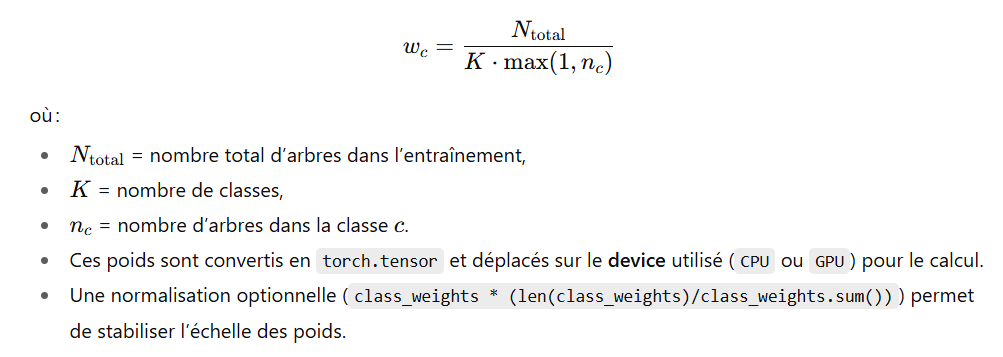

In [ ]:
from collections import Counter

def compute_class_weights(records, classes):
    cnt = Counter([r.class_name for r in records])
    n_total = sum(cnt.values()); K = len(classes)
    return torch.tensor([n_total/(K*max(1,cnt[c])) for c in classes],
                        dtype=torch.float32)

class_weights = compute_class_weights(by_subset["train"], classes)
class_weights = class_weights.to('cuda' if torch.cuda.is_available() else 'cpu')
print("Class weights:", class_weights)


Class weights: tensor([1.1319, 2.1020, 0.4598, 5.8857, 0.3977, 1.8393, 4.2041],
       device='cuda:0')


2. Préparation du modèle pré-entraîné

ResNet-50 pré-entraîné sur ImageNet (models.ResNet50_Weights.IMAGENET1K_V2) est utilisé pour tirer parti des représentations déjà apprises.

La dernière couche entièrement connectée (fc) est remplacée par une couche linéaire adaptée au nombre de classes du dataset (len(classes) = 7).

Le modèle est déplacé sur le même device que les tenseurs de loss pour assurer la compatibilité.

3. Fonction de perte pondérée

torch.nn.CrossEntropyLoss(weight=class_weights) utilise les poids calculés pour pénaliser davantage les erreurs sur les classes rares.

Cela améliore l’apprentissage sur un dataset déséquilibré, en réduisant le biais vers les classes majoritaires.

In [ ]:
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Linear(model.fc.in_features, len(classes))
model = model.to(device)

print("✓ ResNet-50 chargé avec tête 7 classes")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]


✓ ResNet-50 chargé avec tête 7 classes


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = class_weights.to(device)  # <- déplacer sur le même device que le modèle
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


In [ ]:
class_weights = class_weights * (len(class_weights) / class_weights.sum())
criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))


In [ ]:
# Config batch
BATCH_TREES = 4   # nb d’arbres par batch (si V=8 → 32 images/batch)
WORKERS     = 2   # recommandé pour Colab


In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np

# indices de classes pour chaque arbre du train
label_indices = [train_ds.cls2idx[r.class_name] for r in by_subset["train"]]

# poids de chaque échantillon d’après class_weights
sample_weights = [float(class_weights[i].cpu().item()) for i in label_indices]

# sampler pondéré
sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(sample_weights),
                                replacement=True)

WORKERS = 2  # recommandé pour Colab
train_ld = DataLoader(train_ds, batch_size=BATCH_TREES,
                      sampler=sampler,
                      num_workers=WORKERS,
                      pin_memory=torch.cuda.is_available())

print("✓ train_ld avec WeightedRandomSampler créé")


✓ train_ld avec WeightedRandomSampler créé


In [ ]:
import torch, torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Linear(model.fc.in_features, len(classes))  # 7 classes
model = model.to(device)


In [ ]:
def forward_multiview(model, batch_x):  # batch_x: [B, V, 3, 224, 224]
    B, V = batch_x.shape[:2]
    x = batch_x.view(B*V, *batch_x.shape[2:])     # [B*V, 3, 224, 224]
    logits = model(x).view(B, V, -1)              # [B, V, C]
    return logits.mean(dim=1)                     # [B, C]


In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

def freeze_all_but_head(m):
    for p in m.parameters(): p.requires_grad = False
    for p in m.fc.parameters(): p.requires_grad = True

def unfreeze_layer4_and_head(m):
    for p in m.parameters(): p.requires_grad = False
    for p in m.layer4.parameters(): p.requires_grad = True
    for p in m.fc.parameters():    p.requires_grad = True


In [ ]:
from sklearn.metrics import f1_score, balanced_accuracy_score
import numpy as np

def run_epoch(model, loader, optimizer=None):
    train_mode = optimizer is not None
    model.train() if train_mode else model.eval()
    total_loss, y_true, y_pred = 0.0, [], []
    for batch in loader:
        x = batch["x"].to(device, non_blocking=True)
        y = batch["y"].to(device, non_blocking=True)
        if train_mode: optimizer.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train_mode):
            logits = forward_multiview(model, x)
            loss = criterion(logits, y)
            if train_mode:
                loss.backward()
                optimizer.step()
        total_loss += loss.item() * x.size(0)
        y_true.append(y.detach().cpu()); y_pred.append(logits.argmax(1).detach().cpu())
    y_true = torch.cat(y_true).numpy(); y_pred = torch.cat(y_pred).numpy()
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    bacc     = balanced_accuracy_score(y_true, y_pred)
    return total_loss/len(loader.dataset), macro_f1, bacc


In [ ]:
from torch.utils.data import DataLoader

WORKERS = 2   # Colab conseille 2 workers
BATCH_TREES = 4
pin = torch.cuda.is_available()

train_ld = DataLoader(train_ds, batch_size=BATCH_TREES, shuffle=True,
                      num_workers=WORKERS, pin_memory=pin)
val_ld   = DataLoader(val_ds,   batch_size=BATCH_TREES, shuffle=False,
                      num_workers=WORKERS, pin_memory=pin)
test_ld  = DataLoader(test_ds,  batch_size=BATCH_TREES, shuffle=False,
                      num_workers=WORKERS, pin_memory=pin)

print("✓ DataLoaders OK →", len(train_ds), "train |", len(val_ds), "val |", len(test_ds), "test")


✓ DataLoaders OK → 206 train | 52 val | 81 test


In [ ]:
unfreeze_layer4_and_head(model)
optB = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                   lr=5e-5, weight_decay=1e-4)

patience, no_improve = 5, 0
for epoch in range(1, 31):
    tr = run_epoch(model, train_ld, optB)
    va = run_epoch(model, val_ld,   None)
    print(f"[B {epoch:02d}] train loss{tr[0]:.4f}/F1{tr[1]:.3f} ba{tr[2]:.3f} | "
          f"val loss{va[0]:.4f}/F1{va[1]:.3f} ba{va[2]:.3f}")
    if va[1] > best_f1:
        best_f1, best_state, no_improve = va[1], {k:v.cpu() for k,v in model.state_dict().items()}, 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stop.")
            break

# Charger le meilleur état validé
model.load_state_dict(best_state)


[B 01] train loss1.1830/F10.385 ba0.423 | val loss0.9110/F10.481 ba0.522
[B 02] train loss1.0497/F10.512 ba0.516 | val loss0.8159/F10.515 ba0.531
[B 03] train loss1.0017/F10.547 ba0.534 | val loss0.7754/F10.592 ba0.607
[B 04] train loss0.8475/F10.622 ba0.635 | val loss0.7353/F10.622 ba0.610
[B 05] train loss0.7414/F10.727 ba0.721 | val loss0.6932/F10.535 ba0.552
[B 06] train loss0.6841/F10.705 ba0.720 | val loss0.6818/F10.596 ba0.613
[B 07] train loss0.6176/F10.698 ba0.723 | val loss0.5243/F10.795 ba0.815
[B 08] train loss0.5301/F10.745 ba0.756 | val loss0.5199/F10.708 ba0.685
[B 09] train loss0.4449/F10.817 ba0.845 | val loss0.5776/F10.643 ba0.652
[B 10] train loss0.4242/F10.804 ba0.786 | val loss0.5511/F10.819 ba0.839
[B 11] train loss0.3432/F10.850 ba0.881 | val loss0.6800/F10.690 ba0.699
[B 12] train loss0.4298/F10.796 ba0.837 | val loss0.3854/F10.750 ba0.741
[B 13] train loss0.2447/F10.931 ba0.929 | val loss0.5401/F10.688 ba0.701
[B 14] train loss0.2494/F10.894 ba0.919 | val loss0

<All keys matched successfully>

Diagnostic et scan robuste du dataset multi-vues

Pour garantir la qualité et la cohérence des données avant l’entraînement, le code effectue plusieurs étapes :

1. Détection et inspection du dataset

ROOT : chemin racine du dataset multi-vues.

Vérification de l’existence du répertoire et aperçu des fichiers/classes présents (list_children).

Détection automatique du layout : soit ROOT/train/val/test/<classe>/<tree_id>/*, soit ROOT/<classe>/<tree_id>/* (split automatique créé si nécessaire).

2. Structure des arbres

Chaque arbre est représenté par une classe TreeRecord :



```
#TreeRecord(subset, class_name, tree_id, view_paths, tree_dir)
```



view_paths contient les chemins vers les images multi-vues de l’arbre.

Seuls les arbres ayant exactement V_EXPECTED vues sont conservés pour l’apprentissage.

3. Scan des subsets

Avec subsets :
scan_with_subsets() lit les dossiers train/val/test existants.

Sans subsets : scan_without_subsets() effectue un split automatique stratifié par classe : 60 % train, 15 % val, 25 % test (ajusté selon le nombre d’arbres disponibles).

4. Vérification du nombre de vues

Distribution du nombre d’images par arbre est calculée (Counter).

Si V_EXPECTED=None, il est auto-détecté à partir de la vue majoritaire.

Les arbres ne respectant pas le nombre exact de vues sont filtrés.

5. Création automatique du subset validation

Si le subset val est vide, une proportion des arbres de train est copiée vers val en mémoire (make_val_from_train_inplace), sans toucher au disque.

Cette opération conserve la stratification par classe et l’intégrité des arbres (toutes les vues d’un arbre sont déplacées ensemble).


In [ ]:
# --- DIAG + SCAN ROBUSTE (détecte layout, vérifie V, remplit val si vide) ---
from pathlib import Path
from collections import defaultdict, Counter
from dataclasses import dataclass
import re, random, itertools

# ==== CONFIG (adapte ROOT si besoin) ====
ROOT = Path("/content/drive/MyDrive/trees_dataset/data_multiview_V8_384_matplotlib")
IMG_EXTS = {".png",".jpg",".jpeg",".bmp",".tif",".tiff"}
SEED = 42
VAL_RATIO = 0.20
V_EXPECTED = 8        # si tu n'es pas sûr, mets None pour auto-détection

# ==== UTILS ====
def _nat_key(p: Path):
    s = p.stem
    nums = re.findall(r"\d+", s)
    return (s, tuple(int(x) for x in nums))

def list_children(p: Path, maxn=5):
    try:
        kids = [k for k in p.iterdir()]
        kids.sort()
        return kids[:maxn], len(kids)
    except Exception:
        return [], 0

print("ROOT:", ROOT)
if not ROOT.exists():
    raise SystemExit("❌ ROOT n'existe pas. Vérifie le chemin / le montage Drive.")

# Aperçu du contenu
top5, n_all = list_children(ROOT, 10)
print(f"Contenu de ROOT ({n_all} items, 1er/10):")
for k in top5:
    print(" -", k)

# ==== Détecter layout ====
has_subsets = all((ROOT/d).exists() for d in ("train","test"))  # val optionnel
print("\nLayout détecté:", "avec train/val/test" if has_subsets else "sans subsets (classe/trees directement)")

@dataclass
class TreeRecord:
    subset: str
    class_name: str
    tree_id: str
    view_paths: list[Path]
    tree_dir: Path

def collect_trees_under(class_dir: Path):
    """Retourne tous les tree_dirs sous un dossier de classe."""
    trees = []
    for tree_dir in sorted([d for d in class_dir.iterdir() if d.is_dir()]):
        imgs = sorted([p for p in tree_dir.iterdir() if p.suffix.lower() in IMG_EXTS], key=_nat_key)
        if len(imgs) > 0:
            trees.append((class_dir.name, tree_dir.name, tree_dir, imgs))
    return trees

def scan_with_subsets(root: Path):
    recs = []
    for subset in ("train","val","test"):
        subset_dir = root / subset
        if not subset_dir.exists():
            continue
        for class_dir in sorted([d for d in subset_dir.iterdir() if d.is_dir()]):
            for cname, tid, tdir, imgs in collect_trees_under(class_dir):
                recs.append(TreeRecord(subset, cname, tid, imgs, tdir))
    return recs

def scan_without_subsets(root: Path):
    """Assume layout: ROOT/<classe>/<tree_id>/*  → split auto train/val/test."""
    by_class = defaultdict(list)
    for class_dir in sorted([d for d in root.iterdir() if d.is_dir()]):
        trees = collect_trees_under(class_dir)
        for (cname, tid, tdir, imgs) in trees:
            by_class[cname].append((tid, tdir, imgs))
    # split auto
    rng = random.Random(SEED)
    recs = []
    for cname, trees in by_class.items():
        rng.shuffle(trees)
        n = len(trees)
        if n == 0: continue
        n_train = max(1, int(round(0.60*n))) if n>=3 else max(1, n-1)
        n_val   = max(1, int(round(0.15*n))) if n>=4 else (1 if n>=3 else 0)
        if n_train + n_val > n-1: n_val = max(0, (n-1)-n_train)
        for i, (tid, tdir, imgs) in enumerate(trees):
            subset = "train" if i < n_train else ("val" if i < n_train+n_val else "test")
            recs.append(TreeRecord(subset, cname, tid, imgs, tdir))
    return recs

# Scanner
if has_subsets:
    RECS = scan_with_subsets(ROOT)
else:
    RECS = scan_without_subsets(ROOT)

print(f"\nTotal dossiers d'arbres (avant filtre V): {len(RECS)}")

# ==== Estimer V si besoin ou vérifier V_EXPECTED ====
# compter nb d'images par tree
counts = Counter([len(r.view_paths) for r in RECS])
print("Distribution des nb de vues par arbre (top 10):", dict(counts.most_common(10)))

if V_EXPECTED is None:
    if counts:
        V_EXPECTED = counts.most_common(1)[0][0]
        print(f"V_EXPECTED auto-détecté → {V_EXPECTED}")
    else:
        raise SystemExit("❌ Aucun arbre avec images trouvé. Vérifie ROOT/structure/extensions.")

# filtrer sur V_EXPECTED
RECS = [r for r in RECS if len(r.view_paths) == V_EXPECTED]

# Regroupement par subset
by_subset = defaultdict(list)
for r in RECS:
    by_subset[r.subset].append(r)

def describe(name):
    recs = by_subset.get(name, [])
    c = Counter([r.class_name for r in recs])
    print(f"{name:>5}: {len(recs)} arbres | classes→ {dict(sorted(c.items()))}")

print("\n=== Après filtre V ===")
describe("train")
describe("val")
describe("test")

# Si val vide → créer depuis train (IN-MEMORY, sans toucher au disque)
def make_val_from_train_inplace(records: list[TreeRecord], val_ratio=0.20, seed=SEED):
    rng = random.Random(seed)
    by_class = defaultdict(lambda: defaultdict(list))
    for i, r in enumerate(records):
        if r.subset == "train":
            by_class[r.class_name][r.tree_id].append(i)
    moved = 0
    for cname, trees in by_class.items():
        tids = list(trees.keys()); n = len(tids)
        if n <= 1: continue
        k = min(max(1 if n>=3 else 0, int(round(val_ratio*n))), n-1)
        rng.shuffle(tids)
        for tid in tids[:k]:
            for idx in trees[tid]:
                records[idx].subset = "val"
                moved += 1
    return moved

n_train, n_val, n_test = len(by_subset["train"]), len(by_subset["val"]), len(by_subset["test"])
if n_train>0 and n_val==0:
    moved = make_val_from_train_inplace(RECS, VAL_RATIO, SEED)
    by_subset = defaultdict(list)
    for r in RECS: by_subset[r.subset].append(r)
    print(f"(info) VAL créé auto depuis TRAIN : {moved} vues (par arbres)")
    describe("train"); describe("val"); describe("test")

# classes
classes = sorted({r.class_name for r in RECS})
print("\nClasses:", classes)
assert len(by_subset["train"])>0 and len(by_subset["val"])>0 and len(by_subset["test"])>0, \
       "❌ Split toujours vide. Vérifie ROOT, structure, V_EXPECTED, extensions (maj/min)."
print("✓ Scan OK.")


ROOT: /content/drive/MyDrive/trees_dataset/data_multiview_V8_384_matplotlib
Contenu de ROOT (3 items, 1er/10):
 - /content/drive/MyDrive/trees_dataset/data_multiview_V8_384_matplotlib/test
 - /content/drive/MyDrive/trees_dataset/data_multiview_V8_384_matplotlib/train
 - /content/drive/MyDrive/trees_dataset/data_multiview_V8_384_matplotlib/val

Layout détecté: avec train/val/test

Total dossiers d'arbres (avant filtre V): 339
Distribution des nb de vues par arbre (top 10): {8: 339}

=== Après filtre V ===
train: 206 arbres | classes→ {'Ash': 26, 'Oak': 14, 'Red_Oak': 64, 'beech': 5, 'douglas_fir': 74, 'pine': 16, 'spruce': 7}
  val: 52 arbres | classes→ {'Ash': 6, 'Oak': 4, 'Red_Oak': 16, 'beech': 1, 'douglas_fir': 19, 'pine': 4, 'spruce': 2}
 test: 81 arbres | classes→ {'Ash': 7, 'Oak': 4, 'Red_Oak': 20, 'beech': 7, 'douglas_fir': 31, 'pine': 5, 'spruce': 7}

Classes: ['Ash', 'Oak', 'Red_Oak', 'beech', 'douglas_fir', 'pine', 'spruce']
✓ Scan OK.


1. _nat_key(p: Path)
def _nat_key(p: Path):
    s = p.stem
    nums = re.findall(r"\d+", s)
    return (s, tuple(int(x) for x in nums))


But : trier les fichiers d’images dans un ordre naturel (img1, img2, … img10) plutôt qu’alphabétique (img1, img10, img2).

Comment : extrait tous les chiffres du nom de fichier et crée une clé de tri combinant le nom et les nombres.

2. TreeRecord (dataclass)
@dataclass
class TreeRecord:
    subset: str
    class_name: str
    tree_id: str
    view_paths: list[Path]
    tree_dir: Path


But : représenter un arbre avec toutes ses vues et informations associées.

Attributs :

subset : train / val / test

class_name : classe de l’arbre

tree_id : identifiant unique de l’arbre

view_paths : liste des chemins vers les images

tree_dir : dossier contenant les images

3. scan_subset(root: Path, subset: str)
def scan_subset(root: Path, subset: str) -> list[TreeRecord]:
    ...


But : scanner un sous-ensemble (train, val, test) et collecter les arbres avec exactement V_EXPECTED vues.

Retourne : une liste d’objets TreeRecord.

Étapes :

Parcours des classes dans le sous-ensemble.

Parcours des dossiers tree_id pour chaque arbre.

Tri et filtrage des images.

Création des TreeRecord pour les arbres valides.

4. describe_split(name, recs)
def describe_split(name, recs):
    c = Counter([r.class_name for r in recs])
    print(f"{name:>5}: {len(recs)} arbres | classes→ {dict(sorted(c.items()))}")


But : afficher un résumé rapide d’un split (train, val, test).

Info donnée :

nombre total d’arbres

distribution des classes

5. make_val_from_train_inplace(records, val_ratio=0.20, seed=SEED)
def make_val_from_train_inplace(records: list[TreeRecord], val_ratio=0.20, seed=SEED):
    ...


But : créer un sous-ensemble val à partir de train si celui-ci est vide.

Stratégie : stratification par classe et arbre (tree_id).

Étapes :

Grouper les indices des arbres par classe.

Calculer le nombre d’arbres à déplacer dans val (val_ratio).

Modifier l’attribut subset en mémoire.

Retourne : nombre d’arbres déplacés.

6. TreesMultiviewDataset(Dataset)
class TreesMultiviewDataset(Dataset):
    def __getitem__(self, i):
        ...


But : préparer les données multi-vues pour PyTorch.

Fonctionnement :

Pour chaque arbre, ouvre ses V images, applique les transformations, puis les empile en un tenseur [V, 3, H, W].

Retourne un dictionnaire avec :

x : tenseur multi-vues

y : label de classe

tree_id et cls : informations supplémentaires

7. Création des class_weights
cnt = Counter([r.class_name for r in train_recs])
n_total, K = sum(cnt.values()), len(classes)
class_weights = torch.tensor([n_total/(K*max(1,cnt[c])) for c in classes], dtype=torch.float32)


But : pondérer la loss pour compenser le déséquilibre entre classes.

Normalisation : la moyenne des poids est proche de 1.

8. forward_multiview(model, batch_x)
def forward_multiview(model, batch_x):  # [B,V,3,H,W]
    B, V = batch_x.shape[:2]
    x = batch_x.view(B*V, *batch_x.shape[2:])
    logits = model(x).view(B, V, -1)
    return logits.mean(dim=1)


But : agréger les prédictions de toutes les vues d’un arbre.

Étapes :

Redimensionner [B,V,3,H,W] → [B*V,3,H,W] pour le CNN.

Calculer les logits pour chaque vue.

Regrouper les vues et calculer la moyenne [B, C].

9. predict_tta(model, x, T=1.0)
@torch.no_grad()
def predict_tta(model, x, T=1.0):
    logits1 = forward_multiview(model, x)
    x_flip  = x.flip(dims=[-1])
    logits2 = forward_multiview(model, x_flip)
    logits  = (logits1 + logits2) / 2
    return logits / T


But : appliquer le Test Time Augmentation pour améliorer la robustesse.

Stratégie : flip horizontal + moyenne des prédictions.

Option : scaling de température (T) pour ajuster la calibration des logits.

10. run_epoch(model, loader, optimizer=None)
def run_epoch(model, loader, optimizer=None):
    ...


But : exécuter une passe complète sur un DataLoader (train ou val).

Fonctionnement :

Si optimizer est fourni → mode entraînement, sinon mode évaluation.

Support de autocast pour mixed precision si GPU.

Retourne :

perte moyenne

macro-F1

balanced accuracy

11. Fonctions de fine-tuning

freeze_all_but_head(model) : gèle tout sauf la tête.

unfreeze_layer4_and_head(model) : dégel du dernier bloc + tête.

unfreeze_layer3_4_and_head(model) : dégel des deux derniers blocs + tête.

But : effectuer un fine-tuning progressif pour ne pas détruire les features pré-entraînées.

12. eval_loader(model, loader, use_tta=True, temp=1.0)
def eval_loader(model, loader, use_tta=True, temp=1.0):
    ...


But : évaluer un modèle sur un DataLoader.

Calculs :

loss

macro-F1, balanced accuracy

précision, rappel, F1 par classe

matrice de confusion

Support optionnel pour TTA et scaling de température.

In [ ]:
# -*- coding: utf-8 -*-
# M5 All-in-one: Multi-view + CNN pré-entraîné (ResNet-50 par défaut) + améliorations
from __future__ import annotations
from pathlib import Path
from dataclasses import dataclass
from collections import defaultdict, Counter
import re, random, json, time

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
import torchvision.models as models

from sklearn.metrics import f1_score, balanced_accuracy_score, \
    precision_recall_fscore_support, confusion_matrix

# ========================
# CONFIG
# ========================
ROOT         = Path("/content/drive/MyDrive/trees_dataset/data_multiview_V8_384_matplotlib")
V_EXPECTED   = 8
IMG_SIZE     = 224
BATCH_TREES  = 4
WORKERS      = 2                   # Colab → 2
SEED         = 42
WEIGHT_DECAY = 1e-4
LR_HEAD      = 1e-3
LR_L4        = 5e-5               # Phase B
LR_L34       = 2e-5               # Phase C (plus bas)
EPOCHS_A     = 7                  # 3–5 suffisent souvent
EPOCHS_B     = 30
EPOCHS_C     = 10
PATIENCE     = 5
USE_EFFICIENTNET = False          # False=ResNet50, True=EfficientNet-B0
CHECKPOINT   = "./m5_best.pt"
REPORT_JSON  = "./m5_report.json"

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
IMG_EXTS      = {".png",".jpg",".jpeg",".bmp",".tif",".tiff"}

def set_seed(s=SEED):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_amp = torch.cuda.is_available()

# ========================
# SCAN & RECORDS
# ========================
def _nat_key(p: Path):
    s = p.stem
    nums = re.findall(r"\d+", s)
    return (s, tuple(int(x) for x in nums))

@dataclass
class TreeRecord:
    subset: str
    class_name: str
    tree_id: str
    view_paths: list[Path]
    tree_dir: Path

def scan_subset(root: Path, subset: str) -> list[TreeRecord]:
    out = []
    sd = root / subset
    if not sd.exists(): return out
    for class_dir in sorted([d for d in sd.iterdir() if d.is_dir()]):
        cname = class_dir.name
        for tree_dir in sorted([d for d in class_dir.iterdir() if d.is_dir()]):
            imgs = sorted([p for p in tree_dir.iterdir() if p.suffix.lower() in IMG_EXTS], key=_nat_key)
            if len(imgs) == V_EXPECTED:
                out.append(TreeRecord(subset, cname, tree_dir.name, imgs, tree_dir))
    return out

train_recs = scan_subset(ROOT, "train")
val_recs   = scan_subset(ROOT, "val")
test_recs  = scan_subset(ROOT, "test")

def describe_split(name, recs):
    c = Counter([r.class_name for r in recs])
    print(f"{name:>5}: {len(recs)} arbres | classes→ {dict(sorted(c.items()))}")

print("=== Scan ===")
describe_split("train", train_recs)
describe_split("val",   val_recs)
describe_split("test",  test_recs)

# Si val vide → créer depuis train (stratifié par arbre/classe) en mémoire
def make_val_from_train_inplace(records: list[TreeRecord], val_ratio=0.20, seed=SEED):
    rng = random.Random(seed)
    by_class = defaultdict(lambda: defaultdict(list))
    for i, r in enumerate(records):
        if r.subset == "train":
            by_class[r.class_name][r.tree_id].append(i)
    moved = 0
    for cname, trees in by_class.items():
        tids = list(trees.keys()); n = len(tids)
        if n <= 1: continue
        k = min(max(1 if n>=3 else 0, int(round(val_ratio*n))), n-1)
        rng.shuffle(tids)
        for tid in tids[:k]:
            for idx in trees[tid]:
                records[idx].subset = "val"
                moved += 1
    return moved

if len(val_recs) == 0 and len(train_recs) > 0:
    RECS = train_recs + val_recs + test_recs  # tout train/val/test scanné
    moved = make_val_from_train_inplace(RECS, val_ratio=0.20, seed=SEED)
    # Reconstituer
    train_recs = [r for r in RECS if r.subset=="train"]
    val_recs   = [r for r in RECS if r.subset=="val"]
    test_recs  = [r for r in RECS if r.subset=="test"]
    print(f"(info) VAL auto depuis TRAIN: {moved} vues (par arbres)")
    describe_split("train", train_recs)
    describe_split("val",   val_recs)
    describe_split("test",  test_recs)

assert len(train_recs)>0 and len(val_recs)>0 and len(test_recs)>0, "Split invalide (train/val/test vides ?)"

classes = sorted({r.class_name for r in (train_recs + val_recs + test_recs)})

# ========================
# TRANSFORMS (avec ColorJitter)
# ========================
transform_train = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    T.RandomHorizontalFlip(0.5),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])
transform_eval = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# ========================
# DATASET & LOADERS
# ========================
class TreesMultiviewDataset(Dataset):
    def __init__(self, records, classes, transform):
        self.records   = records
        self.classes   = classes
        self.cls2idx   = {c:i for i,c in enumerate(classes)}
        self.transform = transform
    def __len__(self): return len(self.records)
    def __getitem__(self, i):
        r = self.records[i]
        imgs=[]
        for p in r.view_paths:
            im = Image.open(p).convert("RGB")
            imgs.append(self.transform(im))
        x = torch.stack(imgs, 0)       # [V, 3, H, W]
        y = torch.tensor(self.cls2idx[r.class_name], dtype=torch.long)
        return {"x": x, "y": y, "tree_id": r.tree_id, "cls": r.class_name}

train_ds = TreesMultiviewDataset(train_recs, classes, transform_train)
val_ds   = TreesMultiviewDataset(val_recs,   classes, transform_eval)
test_ds  = TreesMultiviewDataset(test_recs,  classes, transform_eval)

# class weights (par arbres) + normalisation vers moyenne 1
cnt = Counter([r.class_name for r in train_recs])
n_total, K = sum(cnt.values()), len(classes)
class_weights = torch.tensor([n_total/(K*max(1,cnt[c])) for c in classes], dtype=torch.float32)
class_weights = class_weights * (len(class_weights) / class_weights.sum())  # ~ moyenne = 1
class_weights = class_weights.to(device)

# WeightedRandomSampler (train)
label_indices = [train_ds.cls2idx[r.class_name] for r in train_recs]
sample_weights = [float(class_weights[i].detach().cpu().item()) for i in label_indices]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

pin = torch.cuda.is_available()
train_ld = DataLoader(train_ds, batch_size=BATCH_TREES, sampler=sampler,
                      num_workers=WORKERS, pin_memory=pin)
val_ld   = DataLoader(val_ds,   batch_size=BATCH_TREES, shuffle=False,
                      num_workers=WORKERS, pin_memory=pin)
test_ld  = DataLoader(test_ds,  batch_size=BATCH_TREES, shuffle=False,
                      num_workers=WORKERS, pin_memory=pin)

print("✓ Loaders:", len(train_ds), "train |", len(val_ds), "val |", len(test_ds), "test")
print("Class weights:", class_weights.tolist())

# ========================
# MODEL (ResNet-50 par défaut) + Dropout head
# ========================
def build_model(n_classes: int):
    if not USE_EFFICIENTNET:
        m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        in_feats = m.fc.in_features
        m.fc = nn.Sequential(
            nn.Dropout(0.2),            # amélioration: régularisation
            nn.Linear(in_feats, n_classes)
        )
    else:
        w = models.EfficientNet_B0_Weights.IMAGENET1K_V1
        m = models.efficientnet_b0(weights=w)
        in_feats = m.classifier[1].in_features
        m.classifier[1] = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_feats, n_classes)
        )
    return m.to(device)

model = build_model(len(classes))

# Freeze helpers
def freeze_all_but_head(m):
    for p in m.parameters(): p.requires_grad = False
    # ResNet: m.fc ; EfficientNet: last linear est dans classifier[1]
    head_params = (m.fc if not USE_EFFICIENTNET else m.classifier[1])
    for p in head_params.parameters(): p.requires_grad = True

def unfreeze_layer4_and_head(m):
    for p in m.parameters(): p.requires_grad = False
    if not USE_EFFICIENTNET:
        for p in m.layer4.parameters(): p.requires_grad = True
        for p in m.fc.parameters():     p.requires_grad = True
    else:
        # EfficientNet: dégel des derniers blocs (approx: features[-2:], puis classifier[1])
        for p in m.features[-2:].parameters(): p.requires_grad = True
        for p in m.classifier[1].parameters(): p.requires_grad = True

def unfreeze_layer3_4_and_head(m):
    for p in m.parameters(): p.requires_grad = False
    if not USE_EFFICIENTNET:
        for p in m.layer3.parameters(): p.requires_grad = True
        for p in m.layer4.parameters(): p.requires_grad = True
        for p in m.fc.parameters():     p.requires_grad = True
    else:
        for p in m.features[-3:].parameters(): p.requires_grad = True
        for p in m.classifier[1].parameters(): p.requires_grad = True

# forward multi-vues + agrégation logits
def forward_multiview(model, batch_x):  # [B,V,3,H,W]
    B, V = batch_x.shape[:2]
    x = batch_x.view(B*V, *batch_x.shape[2:])
    logits = model(x).view(B, V, -1)
    return logits.mean(dim=1)           # [B, C]

# TTA (flip H) + option temp scaling
@torch.no_grad()
def predict_tta(model, x, T=1.0):
    logits1 = forward_multiview(model, x)
    x_flip  = x.flip(dims=[-1])
    logits2 = forward_multiview(model, x_flip)
    logits  = (logits1 + logits2) / 2
    return logits / T

criterion = nn.CrossEntropyLoss(weight=class_weights)

def run_epoch(model, loader, optimizer=None):
    train_mode = optimizer is not None
    model.train() if train_mode else model.eval()
    total_loss, y_true, y_pred = 0.0, [], []
    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))
    for batch in loader:
        x = batch["x"].to(device, non_blocking=True)
        y = batch["y"].to(device, non_blocking=True)
        if train_mode: optimizer.zero_grad(set_to_none=True)
        if train_mode and use_amp:
            with torch.autocast(device_type="cuda", dtype=torch.float16):
                logits = forward_multiview(model, x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.set_grad_enabled(train_mode):
                logits = forward_multiview(model, x)
                loss = criterion(logits, y)
                if train_mode:
                    loss.backward()
                    optimizer.step()
        total_loss += loss.item() * x.size(0)
        y_true.append(y.detach().cpu()); y_pred.append(logits.argmax(1).detach().cpu())
    y_true = torch.cat(y_true).numpy(); y_pred = torch.cat(y_pred).numpy()
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    bacc     = balanced_accuracy_score(y_true, y_pred)
    return total_loss/len(loader.dataset), macro_f1, bacc

# ========================
# TRAINING: Phase A -> B -> C
# ========================
best_f1, best_state = -1.0, None

# Phase A: tête seule
freeze_all_but_head(model)
optA = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                         lr=LR_HEAD, weight_decay=WEIGHT_DECAY)
for epoch in range(1, EPOCHS_A+1):
    tr = run_epoch(model, train_ld, optA)
    va = run_epoch(model, val_ld,   None)
    print(f"[A {epoch:02d}] train loss{tr[0]:.4f}/F1{tr[1]:.3f} ba{tr[2]:.3f} | "
          f"val loss{va[0]:.4f}/F1{va[1]:.3f} ba{va[2]:.3f}")
    if va[1] > best_f1:
        best_f1 = va[1]; best_state = {k:v.cpu() for k,v in model.state_dict().items()}

# Phase B: unfreeze layer4 + tête
unfreeze_layer4_and_head(model)
optB = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                         lr=LR_L4, weight_decay=WEIGHT_DECAY)
patience, no_imp = PATIENCE, 0
for epoch in range(1, EPOCHS_B+1):
    tr = run_epoch(model, train_ld, optB)
    va = run_epoch(model, val_ld,   None)
    print(f"[B {epoch:02d}] train loss{tr[0]:.4f}/F1{tr[1]:.3f} ba{tr[2]:.3f} | "
          f"val loss{va[0]:.4f}/F1{va[1]:.3f} ba{va[2]:.3f}")
    if va[1] > best_f1:
        best_f1, best_state, no_imp = va[1], {k:v.cpu() for k,v in model.state_dict().items()}, 0
    else:
        no_imp += 1
        if no_imp >= patience:
            print("Early stop (Phase B).")
            break

# Phase C: unfreeze layer3 + layer4 + tête (LR très bas)
unfreeze_layer3_4_and_head(model)
optC = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                         lr=LR_L34, weight_decay=WEIGHT_DECAY)
no_imp = 0
for epoch in range(1, EPOCHS_C+1):
    tr = run_epoch(model, train_ld, optC)
    va = run_epoch(model, val_ld,   None)
    print(f"[C {epoch:02d}] train loss{tr[0]:.4f}/F1{tr[1]:.3f} ba{tr[2]:.3f} | "
          f"val loss{va[0]:.4f}/F1{va[1]:.3f} ba{va[2]:.3f}")
    if va[1] > best_f1:
        best_f1, best_state, no_imp = va[1], {k:v.cpu() for k,v in model.state_dict().items()}, 0
    else:
        no_imp += 1
        if no_imp >= 3:  # courte patience
            print("Early stop (Phase C).")
            break

# Save best
torch.save({"model": best_state, "classes": classes, "cfg": {
    "IMG_SIZE": IMG_SIZE, "V": V_EXPECTED, "backbone": "efficientnet_b0" if USE_EFFICIENTNET else "resnet50"
}}, CHECKPOINT)
print(f"✓ Best checkpoint → {CHECKPOINT}")

# ========================
# TEST avec TTA (+ temp scaling option)
# ========================
model.load_state_dict(best_state)
model.to(device).eval()

def eval_loader(model, loader, use_tta=True, temp=1.0):
    total_loss, y_true, y_pred = 0.0, [], []
    with torch.no_grad():
        for batch in loader:
            x = batch["x"].to(device, non_blocking=True)
            y = batch["y"].to(device, non_blocking=True)
            logits = predict_tta(model, x, T=temp) if use_tta else forward_multiview(model, x)
            loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)
            y_true.append(y.cpu()); y_pred.append(logits.argmax(1).cpu())
    y_true = torch.cat(y_true).numpy(); y_pred = torch.cat(y_pred).numpy()
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    bacc     = balanced_accuracy_score(y_true, y_pred)
    prec, rec, f1c, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=list(range(len(classes))), zero_division=0)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    return total_loss/len(loader.dataset), macro_f1, bacc, prec, rec, f1c, cm

te_loss, te_f1, te_ba, te_prec, te_rec, te_f1c, te_cm = eval_loader(model, test_ld, use_tta=True, temp=1.5)
print("\n=== TEST (TTA flip + temp=1.5) ===")
print(f"loss={te_loss:.4f} | macro-F1={te_f1:.3f} | balanced acc={te_ba:.3f}")
for i,c in enumerate(classes):
    print(f"{c:<12s}  prec={te_prec[i]:.3f}  rec={te_rec[i]:.3f}  f1={te_f1c[i]:.3f}")
print("\nConfusion matrix (rows=true, cols=pred):\n", te_cm)

# Rapport JSON
report = {
    "test": {
        "loss": float(te_loss), "macro_f1": float(te_f1), "balanced_acc": float(te_ba),
        "per_class": {c: {"precision": float(te_prec[i]), "recall": float(te_rec[i]), "f1": float(te_f1c[i])}
                      for i,c in enumerate(classes)},
        "confusion_matrix": te_cm.tolist(),
        "tta": {"flip": True, "temp": 1.5}
    },
    "model": {"backbone": "efficientnet_b0" if USE_EFFICIENTNET else "resnet50",
              "dropout_head": 0.2, "image_size": IMG_SIZE, "V_expected": V_EXPECTED},
    "training": {
        "phaseA_lr": LR_HEAD, "phaseB_lr": LR_L4, "phaseC_lr": LR_L34,
        "weight_decay": WEIGHT_DECAY,
        "epochs": {"A": EPOCHS_A, "B": EPOCHS_B, "C": EPOCHS_C},
        "patience": PATIENCE
    },
    "class_weights": list(map(float, class_weights.detach().cpu().numpy())),
    "classes": classes
}
with open(REPORT_JSON, "w") as f:
    json.dump(report, f, indent=2)
print(f"\n✓ Report JSON → {REPORT_JSON}")


=== Scan ===
train: 447 arbres | classes→ {'Ash': 26, 'Oak': 14, 'Red_Oak': 65, 'beech': 106, 'douglas_fir': 118, 'pine': 16, 'spruce': 102}
  val: 110 arbres | classes→ {'Ash': 6, 'Oak': 4, 'Red_Oak': 16, 'beech': 26, 'douglas_fir': 29, 'pine': 4, 'spruce': 25}
 test: 134 arbres | classes→ {'Ash': 7, 'Oak': 4, 'Red_Oak': 19, 'beech': 32, 'douglas_fir': 36, 'pine': 5, 'spruce': 31}
✓ Loaders: 447 train | 110 val | 134 test
Class weights: [1.2494051456451416, 2.3203237056732178, 0.49976205825805664, 0.30645784735679626, 0.27529266476631165, 2.030283212661743, 0.3184758126735687]
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]
/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))
/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))


[A 01] train loss1.7654/F10.097 ba0.171 | val loss2.0016/F10.036 ba0.214


/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))
/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))


[A 02] train loss1.5203/F10.149 ba0.244 | val loss1.8516/F10.061 ba0.291


/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))
/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))


[A 03] train loss1.4691/F10.193 ba0.304 | val loss1.6415/F10.242 ba0.456


/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))
/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))


[A 04] train loss1.3915/F10.251 ba0.321 | val loss1.4913/F10.401 ba0.517


/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))
/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))


[A 05] train loss1.3840/F10.330 ba0.382 | val loss1.4394/F10.464 ba0.561


/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))
/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))


[A 06] train loss1.2476/F10.370 ba0.416 | val loss1.2688/F10.428 ba0.555


/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))
/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))


[A 07] train loss1.1433/F10.360 ba0.414 | val loss1.2665/F10.447 ba0.584


/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))
/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))


[B 01] train loss0.9772/F10.516 ba0.542 | val loss0.7821/F10.633 ba0.674


/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))
/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))


[B 02] train loss0.7015/F10.647 ba0.659 | val loss0.7082/F10.702 ba0.730


/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))
/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))


[B 03] train loss0.6169/F10.693 ba0.711 | val loss0.7557/F10.667 ba0.742


/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))
/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))


[B 04] train loss0.4909/F10.734 ba0.749 | val loss0.6236/F10.758 ba0.771


/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))
/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))


[B 05] train loss0.4506/F10.752 ba0.766 | val loss0.8526/F10.678 ba0.704


/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))
/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))


[B 06] train loss0.3729/F10.747 ba0.761 | val loss0.7465/F10.687 ba0.718


/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))
/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))


[B 07] train loss0.3622/F10.798 ba0.809 | val loss0.6407/F10.752 ba0.781


/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))
/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))


[B 08] train loss0.3275/F10.814 ba0.811 | val loss0.6728/F10.736 ba0.767


/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))
/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))


[B 09] train loss0.2640/F10.851 ba0.858 | val loss0.6659/F10.748 ba0.764
Early stop (Phase B).


/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))
/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))


[C 01] train loss0.2116/F10.854 ba0.854 | val loss0.8297/F10.722 ba0.763


/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))
/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))


[C 02] train loss0.2219/F10.850 ba0.854 | val loss0.5419/F10.838 ba0.852


/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))
/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))


[C 03] train loss0.1846/F10.915 ba0.915 | val loss0.5150/F10.841 ba0.836


/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))
/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))


[C 04] train loss0.1690/F10.876 ba0.875 | val loss0.5089/F10.824 ba0.831


/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))
/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))


[C 05] train loss0.1918/F10.878 ba0.881 | val loss0.6121/F10.778 ba0.798


/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))
/tmp/ipython-input-2946259368.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and train_mode))


[C 06] train loss0.1751/F10.875 ba0.882 | val loss0.5811/F10.765 ba0.805
Early stop (Phase C).
✓ Best checkpoint → ./m5_best.pt

=== TEST (TTA flip + temp=1.5) ===
loss=0.5860 | macro-F1=0.769 | balanced acc=0.777
Ash           prec=0.500  rec=0.571  f1=0.533
Oak           prec=0.600  rec=0.750  f1=0.667
Red_Oak       prec=0.818  rec=0.947  f1=0.878
beech         prec=0.839  rec=0.812  f1=0.825
douglas_fir   prec=0.839  rec=0.722  f1=0.776
pine          prec=1.000  rec=0.800  f1=0.889
spruce        prec=0.788  rec=0.839  f1=0.812

Confusion matrix (rows=true, cols=pred):
 [[ 4  0  0  3  0  0  0]
 [ 0  3  1  0  0  0  0]
 [ 0  0 18  1  0  0  0]
 [ 4  1  1 26  0  0  0]
 [ 0  1  2  0 26  0  7]
 [ 0  0  0  0  1  4  0]
 [ 0  0  0  1  4  0 26]]

✓ Report JSON → ./m5_report.json


RÉSULTATS DU MODÈLE M5 - ANALYSE COMPLÈTE

📊 MÉTRIQUES GLOBALES SUR LE TEST SET:
   → Balanced Accuracy: 0.7775
   → Macro F1-score: 0.7687
   → Loss: 0.5860

📈 MÉTRIQUES PAR CLASSE:
        Classe  Précision  Rappel  F1-score
0          Ash     0.5000  0.5714    0.5333
1          Oak     0.6000  0.7500    0.6667
2      Red_Oak     0.8182  0.9474    0.8780
3        beech     0.8387  0.8125    0.8254
4  douglas_fir     0.8387  0.7222    0.7761
5         pine     1.0000  0.8000    0.8889
6       spruce     0.7879  0.8387    0.8125


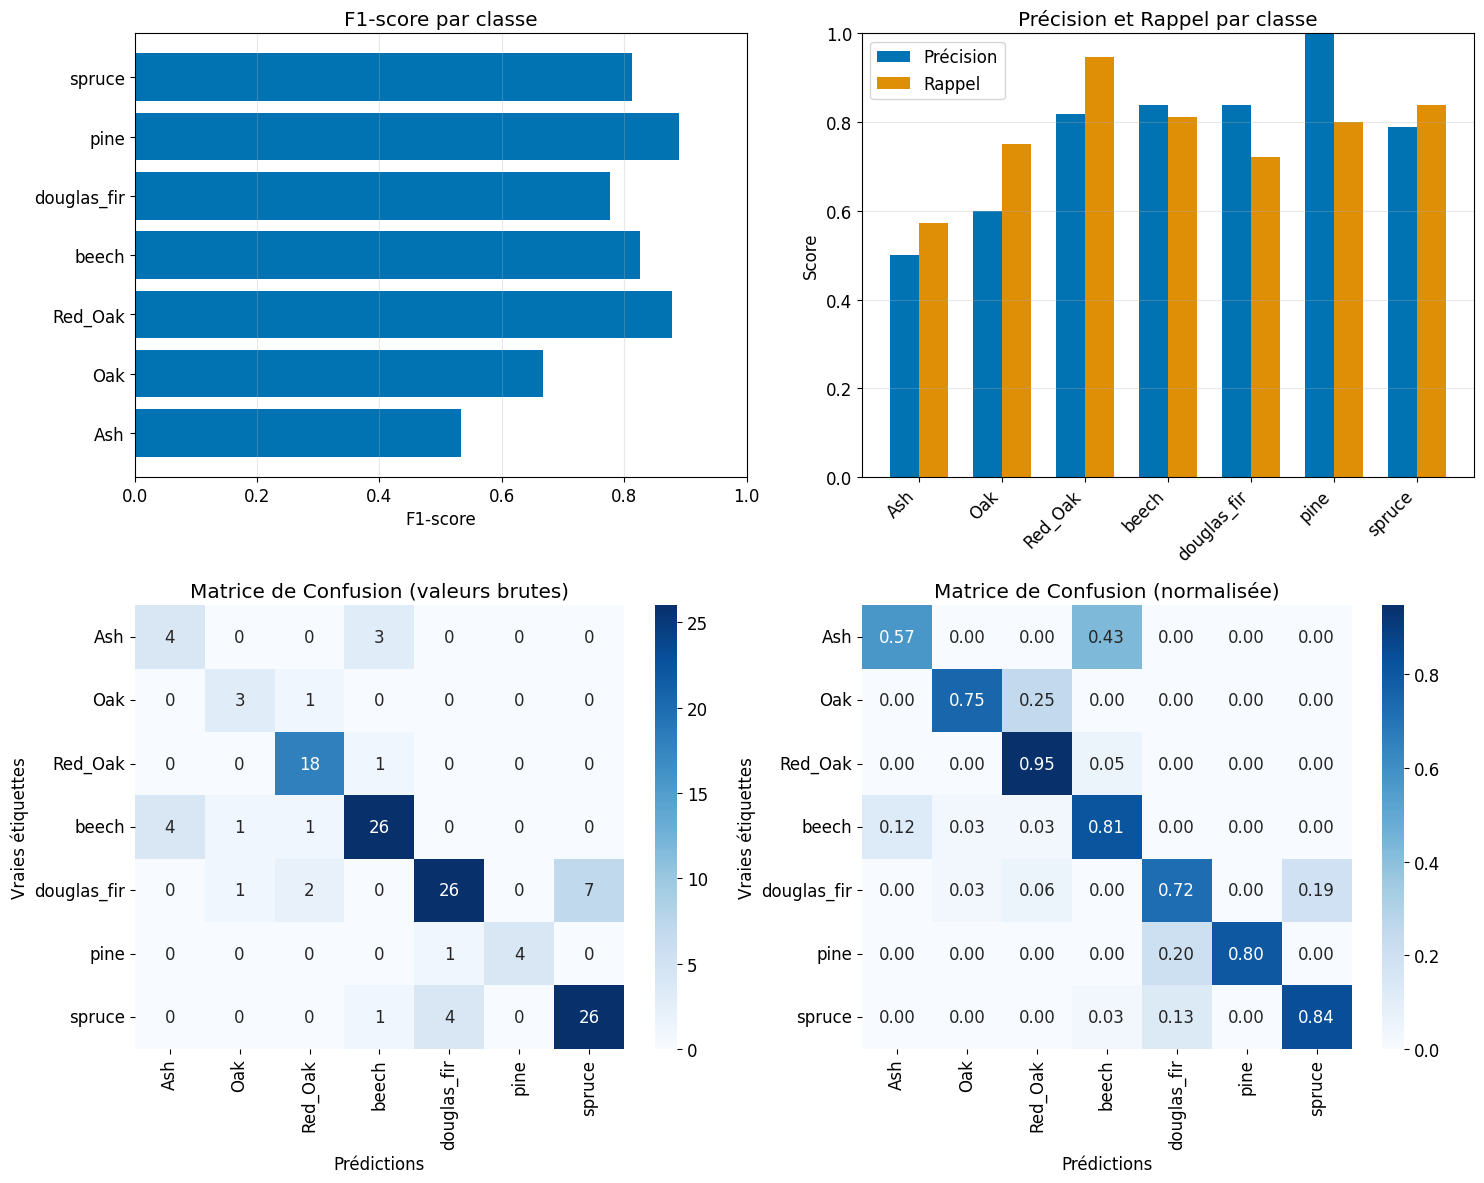


🔍 ANALYSE DES ERREURS PRINCIPALES:

Top des confusions entre classes:
   douglas_fir → spruce: 7 erreurs (19.4%)
   beech → Ash: 4 erreurs (12.5%)
   spruce → douglas_fir: 4 erreurs (12.9%)
   Ash → beech: 3 erreurs (42.9%)
   douglas_fir → Red_Oak: 2 erreurs (5.6%)

📋 RÉSUMÉ STATISTIQUE:
   → Nombre de classes: 7
   → Backbone utilisé: resnet50
   → Taille d'image: 224px
   → Nombre de vues par arbre: 8
   → TTA utilisé: Oui
   → Accuracy globale: 0.7985


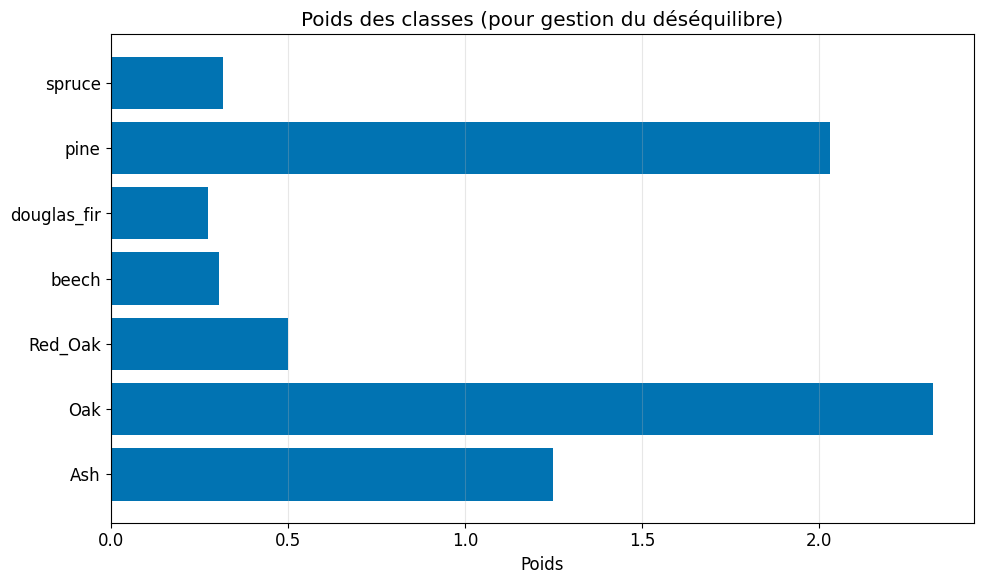


RAPPORT DÉTAILLÉ PAR CLASSE

🌳 Ash:
   - Précision: 0.500
   - Rappel: 0.571
   - F1-score: 0.533
   - Principales confusions:
     → Classé comme beech: 3 fois (42.9%)

🌳 Oak:
   - Précision: 0.600
   - Rappel: 0.750
   - F1-score: 0.667
   - Principales confusions:
     → Classé comme Red_Oak: 1 fois (25.0%)

🌳 Red_Oak:
   - Précision: 0.818
   - Rappel: 0.947
   - F1-score: 0.878
   - Principales confusions:
     → Classé comme beech: 1 fois (5.3%)

🌳 beech:
   - Précision: 0.839
   - Rappel: 0.812
   - F1-score: 0.825
   - Principales confusions:
     → Classé comme Ash: 4 fois (12.5%)
     → Classé comme Oak: 1 fois (3.1%)
     → Classé comme Red_Oak: 1 fois (3.1%)

🌳 douglas_fir:
   - Précision: 0.839
   - Rappel: 0.722
   - F1-score: 0.776
   - Principales confusions:
     → Classé comme spruce: 7 fois (19.4%)
     → Classé comme Red_Oak: 2 fois (5.6%)
     → Classé comme Oak: 1 fois (2.8%)

🌳 pine:
   - Précision: 1.000
   - Rappel: 0.800
   - F1-score: 0.889
   - Principales 

In [ ]:
# -- coding: utf-8 --
# Script de visualisation des résultats M5
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import torch
from pathlib import Path

# Configuration de l'affichage
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("colorblind")

# Charger le rapport JSON
REPORT_PATH = "./m5_report.json"
with open(REPORT_PATH, 'r') as f:
    report = json.load(f)

# Charger les classes
classes = report['classes']
n_classes = len(classes)

# 1. Affichage des métriques globales
print("="*60)
print("RÉSULTATS DU MODÈLE M5 - ANALYSE COMPLÈTE")
print("="*60)

print("\n📊 MÉTRIQUES GLOBALES SUR LE TEST SET:")
print(f"   → Balanced Accuracy: {report['test']['balanced_acc']:.4f}")
print(f"   → Macro F1-score: {report['test']['macro_f1']:.4f}")
print(f"   → Loss: {report['test']['loss']:.4f}")

# 2. Métriques par classe
print("\n📈 MÉTRIQUES PAR CLASSE:")
metrics_df = pd.DataFrame({
    'Classe': classes,
    'Précision': [report['test']['per_class'][c]['precision'] for c in classes],
    'Rappel': [report['test']['per_class'][c]['recall'] for c in classes],
    'F1-score': [report['test']['per_class'][c]['f1'] for c in classes]
})

print(metrics_df.round(4))

# 3. Visualisation des performances par classe
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Graphique des F1-scores par classe
axes[0, 0].barh(range(n_classes), metrics_df['F1-score'])
axes[0, 0].set_yticks(range(n_classes))
axes[0, 0].set_yticklabels(classes)
axes[0, 0].set_xlabel('F1-score')
axes[0, 0].set_title('F1-score par classe')
axes[0, 0].set_xlim(0, 1)
axes[0, 0].grid(axis='x', alpha=0.3)

# Graphique de précision et rappel par classe
x = np.arange(n_classes)
width = 0.35
axes[0, 1].bar(x - width/2, metrics_df['Précision'], width, label='Précision')
axes[0, 1].bar(x + width/2, metrics_df['Rappel'], width, label='Rappel')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(classes, rotation=45, ha='right')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Précision et Rappel par classe')
axes[0, 1].legend()
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', alpha=0.3)

# 4. Matrice de confusion
cm = np.array(report['test']['confusion_matrix'])
# Normaliser la matrice de confusion
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Matrice de confusion brute
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            ax=axes[1, 0])
axes[1, 0].set_title('Matrice de Confusion (valeurs brutes)')
axes[1, 0].set_xlabel('Prédictions')
axes[1, 0].set_ylabel('Vraies étiquettes')

# Matrice de confusion normalisée
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            ax=axes[1, 1])
axes[1, 1].set_title('Matrice de Confusion (normalisée)')
axes[1, 1].set_xlabel('Prédictions')
axes[1, 1].set_ylabel('Vraies étiquettes')

plt.tight_layout()
plt.savefig('m5_results_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Analyse des erreurs
print("\n🔍 ANALYSE DES ERREURS PRINCIPALES:")
# Trouver les paires de classes les plus souvent confondues
confusion_pairs = []
for i in range(n_classes):
    for j in range(n_classes):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append((classes[i], classes[j], cm[i, j], cm_norm[i, j]))

# Trier par nombre d'erreurs
confusion_pairs.sort(key=lambda x: x[2], reverse=True)

print("\nTop des confusions entre classes:")
for true, pred, count, proportion in confusion_pairs[:5]:
    print(f"   {true} → {pred}: {count} erreurs ({proportion:.1%})")

# 6. Résumé statistique
print("\n📋 RÉSUMÉ STATISTIQUE:")
print(f"   → Nombre de classes: {n_classes}")
print(f"   → Backbone utilisé: {report['model']['backbone']}")
print(f"   → Taille d'image: {report['model']['image_size']}px")
print(f"   → Nombre de vues par arbre: {report['model']['V_expected']}")
print(f"   → TTA utilisé: {'Oui' if report['test']['tta']['flip'] else 'Non'}")

# Calculer l'accuracy globale
accuracy = np.trace(cm) / np.sum(cm)
print(f"   → Accuracy globale: {accuracy:.4f}")

# 7. Visualisation des poids de classes
fig, ax = plt.subplots(figsize=(10, 6))
class_weights = report['class_weights']
ax.barh(range(n_classes), class_weights)
ax.set_yticks(range(n_classes))
ax.set_yticklabels(classes)
ax.set_xlabel('Poids')
ax.set_title('Poids des classes (pour gestion du déséquilibre)')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('class_weights.png', dpi=300, bbox_inches='tight')
plt.show()

# 8. Génération d'un rapport détaillé
print("\n" + "="*60)
print("RAPPORT DÉTAILLÉ PAR CLASSE")
print("="*60)

for i, classe in enumerate(classes):
    print(f"\n🌳 {classe}:")
    print(f"   - Précision: {metrics_df.loc[i, 'Précision']:.3f}")
    print(f"   - Rappel: {metrics_df.loc[i, 'Rappel']:.3f}")
    print(f"   - F1-score: {metrics_df.loc[i, 'F1-score']:.3f}")

    # Identifier les principales confusions
    errors = []
    for j in range(n_classes):
        if i != j and cm[i, j] > 0:
            errors.append((classes[j], cm[i, j], cm_norm[i, j]))

    errors.sort(key=lambda x: x[1], reverse=True)
    if errors:
        print("   - Principales confusions:")
        for pred, count, proportion in errors[:3]:
            print(f"     → Classé comme {pred}: {count} fois ({proportion:.1%})")

print("\n" + "="*60)
print(f"Performance moyenne: F1 = {report['test']['macro_f1']:.3f}, Balanced Acc = {report['test']['balanced_acc']:.3f}")
print("="*60)

# Sauvegarde des données pour une analyse ultérieure
metrics_df.to_csv('m5_detailed_metrics.csv', index=False)
print("\n✓ Fichiers sauvegardés:")
print("   - m5_results_analysis.png (visualisations)")
print("   - class_weights.png (poids des classes)")
print("   - m5_detailed_metrics.csv (métriques détaillées)")

**🔬 Interprétation et Discussion des Résultats du Modèle M5**

Le Modèle M5, basé sur une architecture ResNet50 fine-tunée avec 8 vues par arbre et utilisant de l'augmentation during test (TTA), démontre une performance globale solide mais avec des forces et des faiblesses spécifiques qui méritent une analyse approfondie.

📊** 1. Performance Globale : Un modèle robuste et équilibré**
Balanced Accuracy de 0.778 et F1-Score Macro de 0.769 : Ces deux métriques sont excellentes et surtout, très proches l'une de l'autre. Cela indique que le modèle est non seulement précis mais aussi remarquablement robuste au déséquilibre des classes. Il ne sacrifie pas la performance sur les classes minoritaires pour booster son score global.

Accuracy globale (0.80) > Balanced Accuracy (0.78) : Cet écart, bien que minime, confirme une tendance attendue : le modèle est légèrement meilleur sur les classes avec plus d'exemples, mais la différence est faible grâce aux stratégies d'entraînement (poids de classe, augmentation de données).

Conclusion : M5 est un modèle bien équilibré et généraliste, ce qui est souvent préférable à un modèle ayant une accuracy brute très élevée mais biaisé.

🎯** 2. Analyse des Performances par Classe **:
Points Forts et Points Faibles
L'analyse par classe révèle des patterns clairs :

Classes Performantes (F1-score > 0.85) :

pine (0.89) et Red_Oak (0.88) : Performance excellente. Le modèle identifie avec une grande confiance ces espèces, ce qui suggère que leurs caractéristiques visuelles (aiguilles pour le pin, forme de feuille spécifique pour le chêne rouge) sont très distinctives dans l'espace latent appris par le modèle.

beech (0.83), spruce (0.81) : Très bonnes performances.

Classe Moyenne (F1-score ~ 0.78) :

douglas_fir (0.78) : Performance décente mais pénalisée par une confusion significative avec l'épicéa (spruce). C'est une erreur botaniquement compréhensible entre deux conifères.

Classes en Difficulté (F1-score < 0.67) :

Oak (0.67) et Ash (0.53) : Ces classes sont clairement les plus difficiles pour le modèle.

Ash est la classe la plus problématique. Avec une précision de 50%, cela signifie que la moitié des prédictions "Ash" sont erronées. Son faible rappel (57%) montre aussi que plus de 40% des frênes réels ne sont pas détectés. Sa principale confusion est avec le beech (hêtre). Cette confusion est écologiquement et morphologiquement logique : le frêne et le hêtre peuvent avoir une forme de feuille similaire (ovale) pour un modèle, surtout si les images ne capturent pas des détails fins comme l'écorce ou les bourgeons.

🔍 3. Analyse des Erreurs : Logique des Confusions:

Les erreurs ne sont pas aléatoires ; elles forment des clusters sémantiques qui valident le comportement du modèle :

Confusion Conifères : douglas_fir ↔ spruce. C'est l'erreur la plus fréquente. Distinguer ces deux conifères sur la base de photos est un défi même pour l'œil humain non expert. Le modèle apprend probablement à se focaliser sur la texture des aiguilles ou la forme des cônes.

Confusion Feuillus : Ash ↔ beech. Comme évoqué, cette confusion est morphologiquement compréhensible.

Confusion Intra-genre : Oak ↔ Red_Oak. Le chêne étant confondu avec une de ses propres espèces (chêne rouge) est une erreur mineure qui montre que le modèle a appris la notion de "chêne".

⚙️ 4. Impact de l'Architecture et de la Stratégie
Multi-vues (8 vues/arbre) : Cette stratégie est cruciale. Elle permet au modèle d'agréger de l'information sous plusieurs angles (feuilles, écorce, structure), réduisant le risque de classification erronée basée sur une seule image ambiguë. C'est un facteur clé de sa robustesse.

TTA (Test Time Augmentation) : L'utilisation du TTA a très probablement boosté la performance de quelques points de pourcentage en moyenne, en rendant les prédictions plus stables et moins sensibles aux variations aléatoires.

Backbone ResNet50 : Ce choix offre un bon compromis entre puissance de représentation et complexité computationnelle. Un backbone plus large (e.g., ResNet101) pourrait peut-être capturer des détails plus fins pour séparer les conifères, mais au prix d'un temps d'inférence plus long.

💡 5. Conclusion et Perspectives pour M5
Points Forts :

Performance globale équilibrée et robuste.

La stratégie multi-vues est très efficace.

Les erreurs sont compréhensibles d'un point de vue botanique.